In [2]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Global variable to store cached data in memory
global_cache_data_analog = None
global_processed_files_analog = None

In [3]:
import os
import pickle
import re
import numpy as np
from pathlib import Path

def inspect_cache_file(cache_path):
    """Inspect the contents of the cached_results.pkl file and print the number of processed files for each N_ctrl."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            try:
                cached_data, processed_files = pickle.load(f)
                print(f"Cache file loaded successfully from: {cache_path}")

                # Print the total number of processed files
                print(f"\n---- Total Number of Processed Files: {len(processed_files)} ----")

                print("\n---- Number of Processed Files for Each N_ctrl ----")
                for N_ctrl, gates_data in cached_data.items():
                    # Calculate the number of processed files for this N_ctrl
                    num_processed_for_ctrl = sum(
                        len(runs_data) for gate_data in gates_data.values()
                        for reservoir_data in gate_data.values()
                        for runs_data in reservoir_data.values()
                    )
                    print(f"N_ctrl={N_ctrl}: {num_processed_for_ctrl} processed files.")

            except (EOFError, pickle.UnpicklingError) as e:
                print(f"Error loading cache file: {e}")
    else:
        print(f"Cache file not found: {cache_path}")
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data  # Return as is if not an array or collection

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        
    # Clean any deprecated arrays in the data
    df = clean_array(df)
    with open(file_path, 'wb') as f:
        
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    costs = [float(i) for i in df['costs'][0]]
    fidelity = df['avg_fidelity'][0]
    test_results = [float(a) for a in df['testing_results'][0]]
    num_params = 3 + int(df['trotter_step'][0]) + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
    grads_per_epoch = df['grads_per_epoch'][0]
    try:
        selected_indices = df['selected_indices'][0]
    except KeyError:
        selected_indices = None
    return costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices



def get_cached_data(cache_file):
    """Load cached data and list of processed files from a specified cache path."""
    start_time = time.time()
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
            # Clean arrays to ensure compatibility
            cached_data = clean_array(cached_data)
        load_time = time.time() - start_time
        print(f"Loaded {len(processed_files)} processed files from cache. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file not found: {cache_file}")
        return {}, set()
def get_cached_data_once(base_path, N_ctrl = None):
    """Load cached data only once and keep it in memory for future runs, with different cache paths based on N_ctrl."""
    global global_cache_data_analog, global_processed_files_analog
    start_time = time.time()

    # Define cache file based on N_ctrl
   
    cache_file = os.path.join(base_path, 'cached_results.pkl')

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_analog is not None and global_processed_files_analog is not None:
        print("Using cached data from memory, not reloading from disk.")
        return global_cache_data_analog, global_processed_files_analog

    # Load the cache from disk (only happens once)
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_analog, global_processed_files_analog = pickle.load(f)
        print(f"Cache file loaded from disk: {cache_file}")
        global_cache_data_analog = clean_array(global_cache_data_analog)
        load_time = time.time() - start_time
        print(f"Loaded {len(global_processed_files_analog)} processed files from cache. Took {load_time:.2f}s.")
        return global_cache_data_analog, global_processed_files_analog
    else:
        print(f"Cache file not found: {cache_file}")
        global_cache_data_analog = {}
        global_processed_files_analog = set()
        return global_cache_data_analog, global_processed_files_analog
def get_cached_data_for_N_ctrl(base_path, N_ctrl = 1):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    cache_file = os.path.join(base_path, f'results_Nc_{N_ctrl}.pkl')
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set()  # Return empty structures if no cache exists
def get_cached_data_direct_path(cache_file, N_ctrl):
    """Load cached data specific to the given N_ctrl value and return its contents."""
    
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set() 
def save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl):
    """Save cached data and processed files specific to the given N_ctrl value."""
    cache_file = os.path.join(base_path, f'results_Nc_{N_ctrl}.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache for N_ctrl={N_ctrl} saved to {cache_file}")


def process_files_by_N_ctrl(base_path, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_for_N_ctrl(base_path, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        base_path, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )

    # Save the updated cache for current N_ctrl
    save_cached_data_for_N_ctrl(base_path, cached_data, processed_files, N_ctrl)

def get_cached_data_direct_path(filepath, N_ctrl):
    start_time = time.time()
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files

def process_files_by_direct_path(filepath, gate_prefixes, reservoir_counts, trots, N_ctrl):
    """Main process to load, update, and save cache for each N_ctrl."""
    # Load cached data for current N_ctrl
    cached_data, processed_files = get_cached_data_direct_path(filepath, N_ctrl)

    # Process new files and update the cache
    cached_data, processed_files = process_new_files(
        filepath, gate_prefixes, reservoir_counts, trots,
        cached_data, processed_files, N_ctrl
    )





def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and processed files."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)

def process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # Ensure N_ctrl is in cached_data
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}
                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    for data_point in cached_trotter_data:
                                        if 'file_path' not in data_point or data_point['file_path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith(base_path):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['file_path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                    
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has already been processed
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)
                                                run = os.path.basename(pickle_file).replace('.pickle', '')
                                                num_data_runs += 1  # Increment the number of data runs

                                                # Process the file if it's valid
                                                if is_valid_pickle_file(Path(pickle_file)):
                                                    # if N_ctrl == 2 and trotter_step >20:
                                                    #     print(pickle_file)
                                                    costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)

                                                    # Update the best fidelity
                                                    if fidelity > current_best_fidelity:
                                                        current_best_fidelity = fidelity
                                                        current_best_data_point = {
                                                            'costs': costs,
                                                            'gate': gate,
                                                            'fidelity': fidelity,
                                                            'test_results': test_results,
                                                            'param_count': num_params,
                                                            'run': run,  # Store the data_run_<i> value
                                                            'grads_per_epoch': grads_per_epoch,
                                                            'selected_indices': selected_indices,
                                                            'file_path': pickle_file  # Add the file path
                                                        }

                                                    # Add processed file to the global set
                                                    processed_files.add(pickle_file)

                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]

    return cached_data, processed_files


def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # print(f"Processing gate: {gate}")

                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue
                            # print(f"Processing reservoir: {reservoir_count}")

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue
                                    # print(f"Processing trotter step: {trotter_step}")

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    # Ensure that N_ctrl is in cached_data
                                    if N_ctrl not in cached_data:
                                        cached_data[N_ctrl] = {}

                                    # Initialize the cached_trotter_data
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # print(f"Skipping file {pickle_file}, already processed.")
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run
                                                    if 'gate' not in cached_result or cached_result['gate'] != gate:
                                                        cached_result['gate'] = gate
                                                    
                                                    # # Load file and check for 'selected_indices'
                                                    # if 'selected_indices' not in cached_result:
                                                    #     print(f"Missing data in {pickle_file}, adding now...")
                                                    #     with open(pickle_file, 'rb') as f:
                                                    #         df = pickle.load(f)
                                                    #         if 'selected_indices' in df:
                                                    #             selected_indices = df['selected_indices'][0]
                                                    #             cached_result['selected_indices'] = selected_indices
                                                    #             print(f"Added selected indices {selected_indices} to test {gate}, dt: {trotter_step} for run {run} to cache")
                                                    #         else:
                                                    #             print(f"No 'selected_indices' found in file: {pickle_file}")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results,grads_per_epoch,selected_indices = read_jax_file(pickle_file, gate)
                                                avg_fidelity = np.mean(test_results)

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                                # Increment the data run count since we're adding a new run
                                                num_data_runs += 1

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    'path':pickle_file
                                                    # 'selected_indices':selected_indices
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)

                                                # Mark the file as processed
                                                processed_files.add(pickle_file)
                                                print(f"Added new file to cache: {pickle_file}")

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files





# reservoir_counts = [1, 2, 3]
# N_ctrl = 3

# nctrl3_path = '/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_20_optimized_by_cost3/0/cached_results.pkl'

# gate_prefixes = [f'U{N_ctrl}']
# trots =np.arange(3, 54, 1)
num_epochs = 1500

# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2, 3]
num_train = 20
reservoir_counts = [1, 2, 3,4,5,6,7,8]
# base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch{num_epochs}_case1/0/'
base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch{num_epochs}_case1/0/'
cached_data, processed_files = get_cached_data_once(base_path)

Cache file loaded from disk: /Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_20_epoch1500_case1/0/cached_results.pkl
Loaded 723 processed files from cache. Took 30.76s.


In [5]:
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data, processed_files = process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl)
  
    save_cached_data(base_path, cached_data, processed_files)

    global_processed_files_analog.update(processed_files)

In [7]:
N_ctrls = [2,3]
jitter_scale = 1e-9
min_error = 1e-10
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    if 1.0 - avg_fidelity <= 0 and N_ctrl == 2:
                        print(f"{gate} N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}: {results['fidelity']}")
                    log_infidelities = []
                    infidelites = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'N_R': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            infidelity = 1.0 - fidelity

                            # Ensure infidelity is not zero
                            if infidelity <= 0:
                                print(f"infidel < 0?")
                                infidelity = np.abs(infidelity) if infidelity < 0 else min_error

                            infidelites.append(infidelity)
                            log_infidelity = np.log(infidelity)  # Use max to avoid log10(0)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'N_R': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Avg_infidelity': 1.0-avg_fidelity,
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'infidelities':infidelites,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                   
                    rows.append(row)
# Report any issues found
if negative_fidelity_values:
    print("Negative fidelity values detected!")
    for issue in negative_fidelity_values:
        print(f"Gate: {issue['Gate']}, N_R: {issue['N_R']}, Trotter_Step: {issue['Trotter_Step']}, Fidelity: {issue['Fidelity']}")
else:
    print("No negative fidelity values detected.")
# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)

No negative fidelity values detected.


In [32]:
data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 40) & (all_data_df['N_C'] == 3) & (all_data_df['Avg Error'] < -9)]
# data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 40) & (all_data_df['N_C'] == 3) & (all_data_df['Avg Error'] > -6)]
# data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 45) & (all_data_df['N_C'] == 3)]
print(len(data_trot10))
data_trot10

10


,N_C,Trotter_Step,Gate,N_R,Avg_Fidelity,Avg_infidelity,Error_Test_Results,Avg Error,infidelities,Costs,Test Results,N_params,run
509,3,40,U3_4,1,0.999985,0.000015,"[-10.955359724421621, -10.905432550465113, -11...",-11.106103,"[1.7464160919189453e-05, 1.8358230590820312e-0...","[0.8379940390586853, 0.8761628866195679, 0.883...","[0.9999825358390808, 0.9999816417694092, 0.999...",163,data_run_0
543,3,40,U3_7,1,0.999899,0.000101,"[-9.223371998493482, -9.07962723982734, -9.426...",-9.196561,"[9.870529174804688e-05, 0.00011396408081054688...","[0.8484407663345337, 0.8747422099113464, 0.858...","[0.999901294708252, 0.9998860359191895, 0.9999...",163,data_run_0
554,3,40,U3_8,1,0.999965,0.000035,"[-10.51743513539734, -10.567106745194577, -10....",-10.260508,"[2.7060508728027344e-05, 2.574920654296875e-05...","[0.8608710169792175, 0.8824368119239807, 0.880...","[0.999972939491272, 0.999974250793457, 0.99996...",163,data_run_0
599,3,40,U3_13,1,0.999987,0.000013,"[-11.260253925754522, -11.302813540173318, -11...",-11.228361,"[1.2874603271484375e-05, 1.233816146850586e-05...","[0.8702661395072937, 0.8699038624763489, 0.834...","[0.9999871253967285, 0.9999876618385315, 0.999...",163,data_run_0
632,3,40,U3_16,1,0.999984,0.000016,"[-11.07485070242316, -11.146594607282001, -11....",-11.040821,"[1.5497207641601562e-05, 1.4424324035644531e-0...","[0.8898019194602966, 0.876605749130249, 0.8854...","[0.9999845027923584, 0.9999855756759644, 0.999...",163,data_run_0
674,3,40,U3_20,1,0.999934,0.000066,"[-9.463875510670173, -9.743906436386434, -10.0...",-9.627027,"[7.76052474975586e-05, 5.8650970458984375e-05,...","[0.8751446604728699, 0.8693027496337891, 0.882...","[0.9999223947525024, 0.999941349029541, 0.9999...",163,data_run_0
683,3,40,U3_21,1,0.999982,0.000018,"[-10.915220556831276, -10.948556977098868, -10...",-10.902191,"[1.817941665649414e-05, 1.7583370208740234e-05...","[0.8729906678199768, 0.8728187680244446, 0.898...","[0.9999818205833435, 0.9999824166297913, 0.999...",163,data_run_0
692,3,40,U3_22,1,0.999983,0.000017,"[-10.958778531170406, -10.99008543579545, -10....",-10.969106,"[1.7404556274414062e-05, 1.6868114471435547e-0...","[0.8787674307823181, 0.8828489780426025, 0.860...","[0.9999825954437256, 0.9999831318855286, 0.999...",163,data_run_0
728,3,40,U3_26,1,0.999985,0.000015,"[-11.098198066420151, -11.102142844711167, -11...",-11.114071,"[1.5139579772949219e-05, 1.5079975128173828e-0...","[0.8984137177467346, 0.8551871180534363, 0.888...","[0.999984860420227, 0.9999849200248718, 0.9999...",163,data_run_0
746,3,40,U3_28,1,0.999986,0.000014,"[-11.167472192303556, -11.102142844711167, -11...",-11.159069,"[1.4126300811767578e-05, 1.5079975128173828e-0...","[0.8977030515670776, 0.8785086274147034, 0.855...","[0.9999858736991882, 0.9999849200248718, 0.999...",163,data_run_0


In [27]:
# data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 45) & (all_data_df['N_C'] == 3) & (all_data_df['Avg Error'] < -7)]
data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 45) & (all_data_df['N_C'] == 3) & (all_data_df['Avg Error'] > -7)]
# data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 45) & (all_data_df['N_C'] == 3)]
print(len(data_trot10))
data_trot10

15


,N_C,Trotter_Step,Gate,N_R,Avg_Fidelity,Avg_infidelity,Error_Test_Results,Avg Error,infidelities,Costs,Test Results,N_params,run
456,3,45,U3_0,1,0.995598,0.004402,"[-5.918828291313192, -5.36881435938122, -5.574...",-5.425592,"[0.0026883482933044434, 0.0046596527099609375,...","[0.884802520275116, 0.9013029336929321, 0.8477...","[0.9973116517066956, 0.9953403472900391, 0.996...",183,data_run_0
468,3,45,U3_1,1,0.998530,0.001470,"[-6.405947608177968, -6.032567676647744, -6.57...",-6.522797,"[0.0016517043113708496, 0.0023993253707885742,...","[0.8573358058929443, 0.8734815716743469, 0.861...","[0.9983482956886292, 0.9976006746292114, 0.998...",183,data_run_0
479,3,45,U3_10,1,0.998882,0.001118,"[-6.5403506178619395, -7.011031434987117, -7.1...",-6.795997,"[0.0014439821243286133, 0.0009018778800964355,...","[0.8255124092102051, 0.8609758019447327, 0.912...","[0.9985560178756714, 0.9990981221199036, 0.999...",183,data_run_0
491,3,45,U3_2,1,0.998804,0.001196,"[-6.826190638792789, -6.8162963333501505, -6.9...",-6.728850,"[0.0010849833488464355, 0.0010957717895507812,...","[0.857729971408844, 0.8958377242088318, 0.8952...","[0.9989150166511536, 0.9989042282104492, 0.999...",183,data_run_0
503,3,45,U3_3,1,0.998233,0.001767,"[-6.637098303593606, -6.097798708262775, -6.34...",-6.338416,"[0.0013108253479003906, 0.0022478103637695312,...","[0.9053207635879517, 0.9016598463058472, 0.900...","[0.9986891746520996, 0.9977521896362305, 0.998...",183,data_run_0
515,3,45,U3_4,1,0.997193,0.002807,"[-5.694032114363379, -6.009605824040585, -6.03...",-5.875801,"[0.0033659934997558594, 0.0024550557136535645,...","[0.8707213401794434, 0.8723544478416443, 0.883...","[0.9966340065002441, 0.9975449442863464, 0.997...",183,data_run_0
526,3,45,U3_5,1,0.998825,0.001175,"[-6.732795062293263, -6.532661277152688, -6.38...",-6.746752,"[0.0011911988258361816, 0.0014551281929016113,...","[0.8756735920906067, 0.8898118138313293, 0.913...","[0.9988088011741638, 0.9985448718070984, 0.998...",183,data_run_0
537,3,45,U3_6,1,0.999056,0.000944,"[-6.711115337721529, -7.12575425799987, -6.842...",-6.965049,"[0.0012173056602478027, 0.0008041262626647949,...","[0.8784541487693787, 0.8753613233566284, 0.894...","[0.9987826943397522, 0.9991958737373352, 0.998...",183,data_run_0
570,3,45,U3_9,1,0.997567,0.002433,"[-5.964764628501387, -5.929594865452164, -6.03...",-6.018605,"[0.0025676488876342773, 0.0026595592498779297,...","[0.8703204989433289, 0.8691418170928955, 0.847...","[0.9974323511123657, 0.9973404407501221, 0.997...",183,data_run_0
581,3,45,U3_11,1,0.996659,0.003341,"[-5.7732502695016805, -5.465054924786763, -5.6...",-5.701355,"[0.0031096339225769043, 0.0042321085929870605,...","[0.8700360655784607, 0.8937555551528931, 0.834...","[0.9968903660774231, 0.9957678914070129, 0.996...",183,data_run_0


In [21]:
data_trot10 = all_data_df[(all_data_df['Trotter_Step'] == 10) & (all_data_df['Avg_Fidelity'] < 0.9)]
print(len(data_trot10))
data_trot10.head()

5


,N_C,Trotter_Step,Gate,N_R,Avg_Fidelity,Avg_infidelity,Error_Test_Results,Avg Error,infidelities,Costs,Test Results,N_params,run
406,3,10,U3_0,1,0.454285,0.545715,"[-0.31481373760344633, -0.3097051334473079, -0...",-0.263034,"[0.4843800663948059, 0.49011147022247314, 0.63...","[0.8713110685348511, 0.8669270277023315, 0.911...","[0.5156199336051941, 0.5098885297775269, 0.362...",43,data_run_0
422,3,10,U3_1,1,0.539749,0.460251,"[-0.25517439024697, -0.29639577476998874, -0.3...",-0.337005,"[0.5556810796260834, 0.5053639113903046, 0.496...","[0.8866404294967651, 0.8657047748565674, 0.839...","[0.4443189203739166, 0.49463608860969543, 0.50...",43,data_run_0
443,3,10,U3_2,1,0.528980,0.471020,"[-0.4759439531296667, -0.36075778479126674, -0...",-0.326961,"[0.3342381715774536, 0.43575483560562134, 0.37...","[0.8791772127151489, 0.8568685054779053, 0.883...","[0.6657618284225464, 0.5642451643943787, 0.626...",43,data_run_0
454,3,10,U3_3,1,0.577619,0.422381,"[-0.32685939286547094, -0.5881330157930391, -0...",-0.374296,"[0.471129834651947, 0.2581469416618347, 0.3712...","[0.8865445256233215, 0.9048084020614624, 0.893...","[0.528870165348053, 0.7418530583381653, 0.6287...",43,data_run_0
465,3,10,U3_4,1,0.504312,0.495688,"[-0.4762665650314339, -0.2669077918059554, -0....",-0.304791,"[0.3339899778366089, 0.5408691465854645, 0.574...","[0.8251237273216248, 0.867661714553833, 0.8846...","[0.6660100221633911, 0.4591308534145355, 0.425...",43,data_run_0


global_min_y: -15.060202689699473, global_max_y: -0.00016063217369752632
global_min_fidelity: 0.3771391666453818, global_max_fidelity: 0.9999964733918508
global_min_y: -16.56622295866942, global_max_y: 0.3
global_min_fidelity: 0.3771391666453818, global_max_fidelity: 0.9999964733918508
[np.float64(-16.0), np.float64(-14.0), np.float64(-12.0), np.float64(-10.0), np.float64(-8.0), np.float64(-6.0), np.float64(-4.0), np.float64(-2.0), np.float64(0.0)]
min val: -13.691093354272247, -14.0


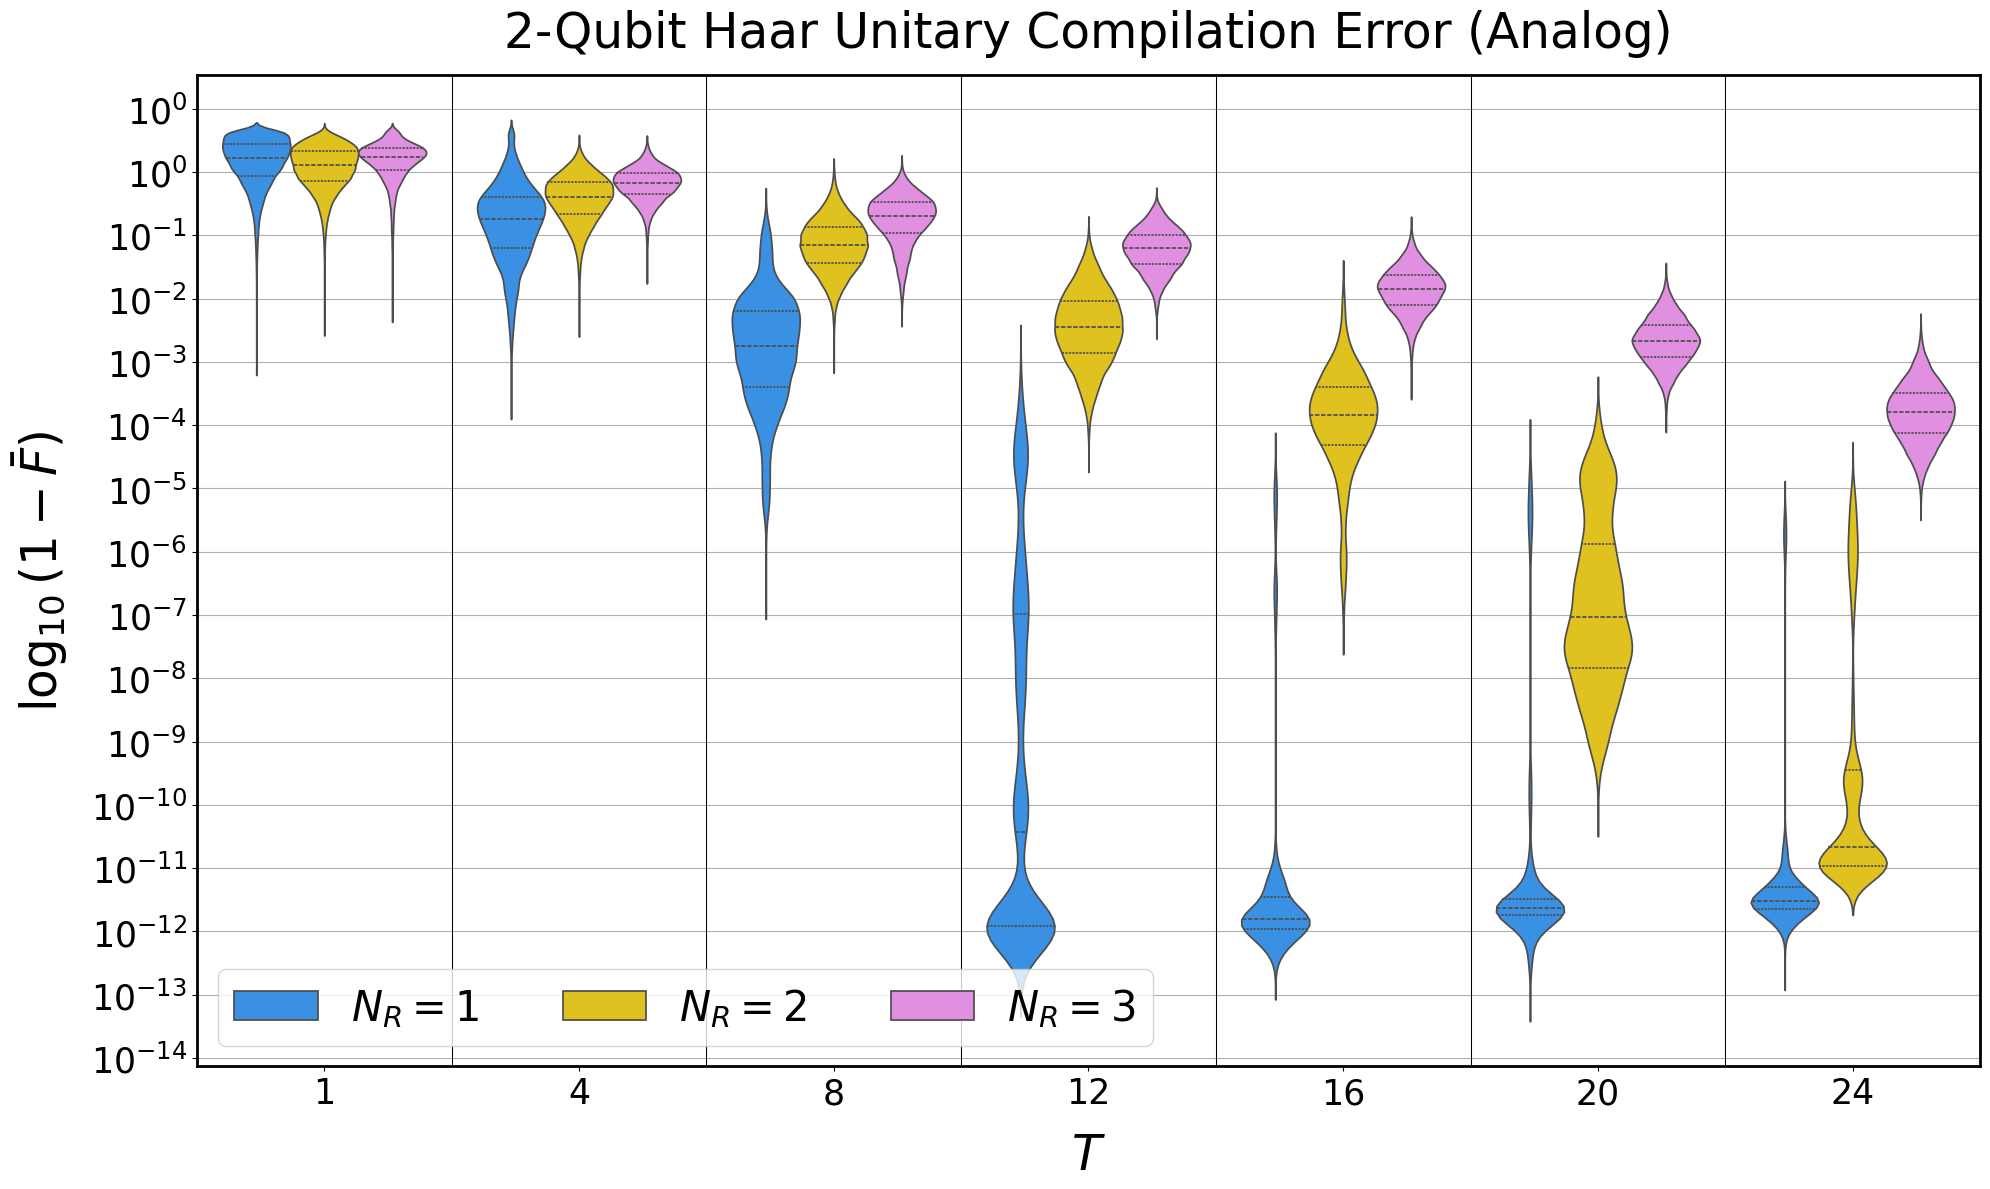

In [34]:
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

global_max_y = float('-inf')
N_ctrls = [2]
resies = [1,2,3]
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# First pass to determine the global min and max y-values across all plots
for N_ctrl in N_ctrls:
    
    if N_ctrl == 2:
        trots = [1,4,8, 10, 11, 12, 13, 14, 16, 17,18, 20, 22, 24, 26, 28]

    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
        
    else:
        trots = np.arange(1, 50, 1)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and N_R
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'N_R'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results)
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")

custom_palette = ['dodgerblue', 'gold', 'violet'] 
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16,18, 20,24]
        trots = [1,2,3, 4, 5, 6, 8, 10, 12, 14, 16,18, 20,24]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8]
    # print(trots)
    trots = np.arange(1,50,1)
    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]

    # Aggregate average fidelity by Trotter_Step and N_R
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'N_R'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results)
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y = 0.3
print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")

# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    # if N_ctrl == 2:
    #     trots = [1, 6, 8, 10, 12, 14,16, 20,24]
    # elif N_ctrl == 1:
    #     trots = [1, 2, 3, 4, 5,6,7,8]
    trots = np.arange(1,50,1)

    # Filter the DataFrame for specific N_C (control qubits)
    # data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    # data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    # Filter the DataFrame for specific N_C (control qubits) and Trotter steps
    # data_df = all_data_df[all_data_df['N_R'] ]
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['N_R'].isin(resies)]
    data_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Trotter_Step'].isin(trots))]


    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Analog)", fontsize=35, pad=20)

    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30, ncol=len(labels))

    # Set the global Y-limits
    # axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    print(whole_y_ticks)
    min_value = np.min(np.concatenate(data_df['Error_Test_Results'].values))
    print(f"min val: {min_value}, {round(min_value,0)}")
    min_tick = min_value - 1
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()

In [ ]:

# Specify the column for which you want to find the minimum
specified_column = 'Avg Error'

# Filter the DataFrame for rows where N_C is equal to 3
filtered_df = all_data_df[all_data_df['N_C'] == 3]

# Find and print the minimum of the specified column
min_value = filtered_df[specified_column].min()
print(f"The minimum of '{specified_column}' for rows where 'N_C' is 3: {min_value}")
specified_column2 = 'Error_Test_Results'
min_value = np.min(np.concatenate(filtered_df['Error_Test_Results'].values))
print(f"The minimum value across the arrays in '{specified_column2}' for rows where 'N_C' is 3: {min_value}")

The minimum of 'Avg Error' for rows where 'N_C' is 3: -11.57928652809038
The minimum value across the arrays in 'Error_Test_Results' for rows where 'N_C' is 3: -11.730257555000257


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_32419/776914905.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.9f}".format)


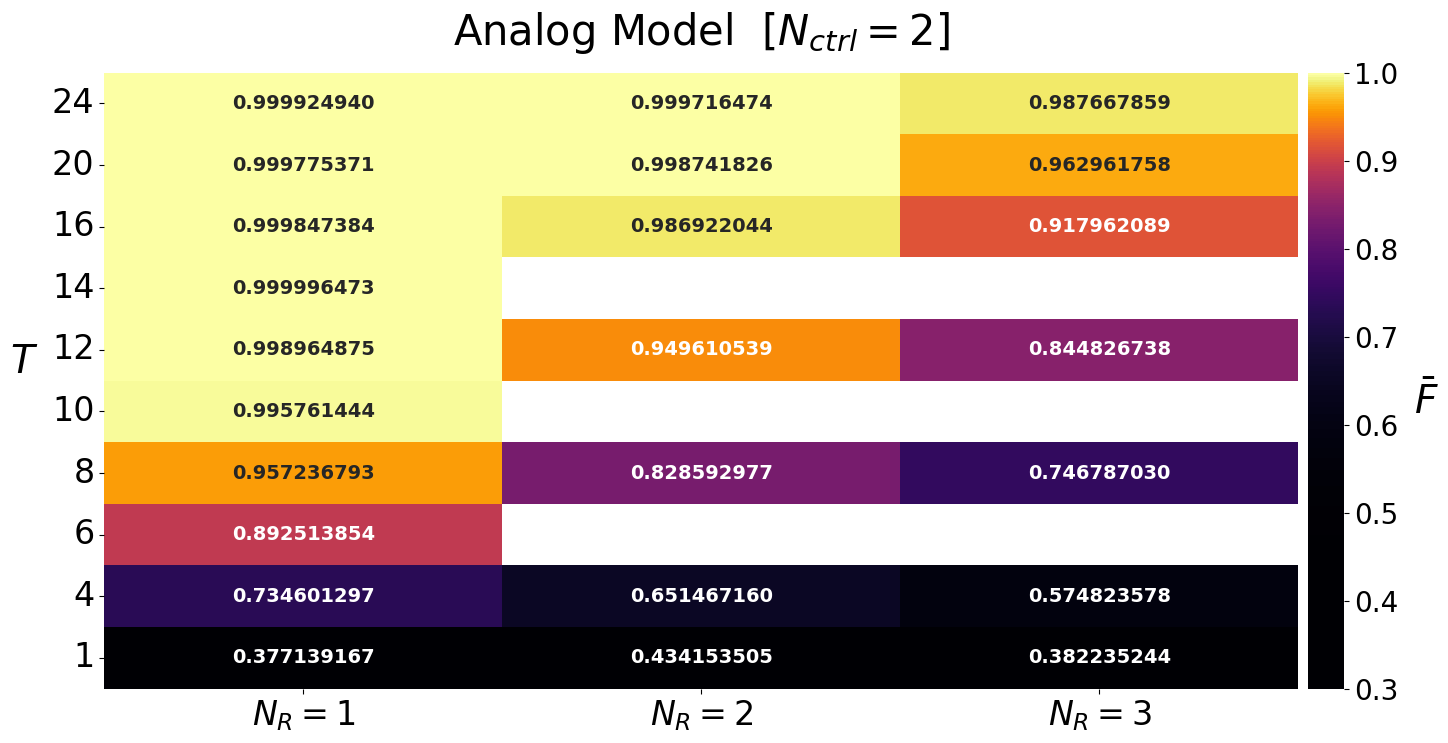

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_32419/776914905.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.9f}".format)


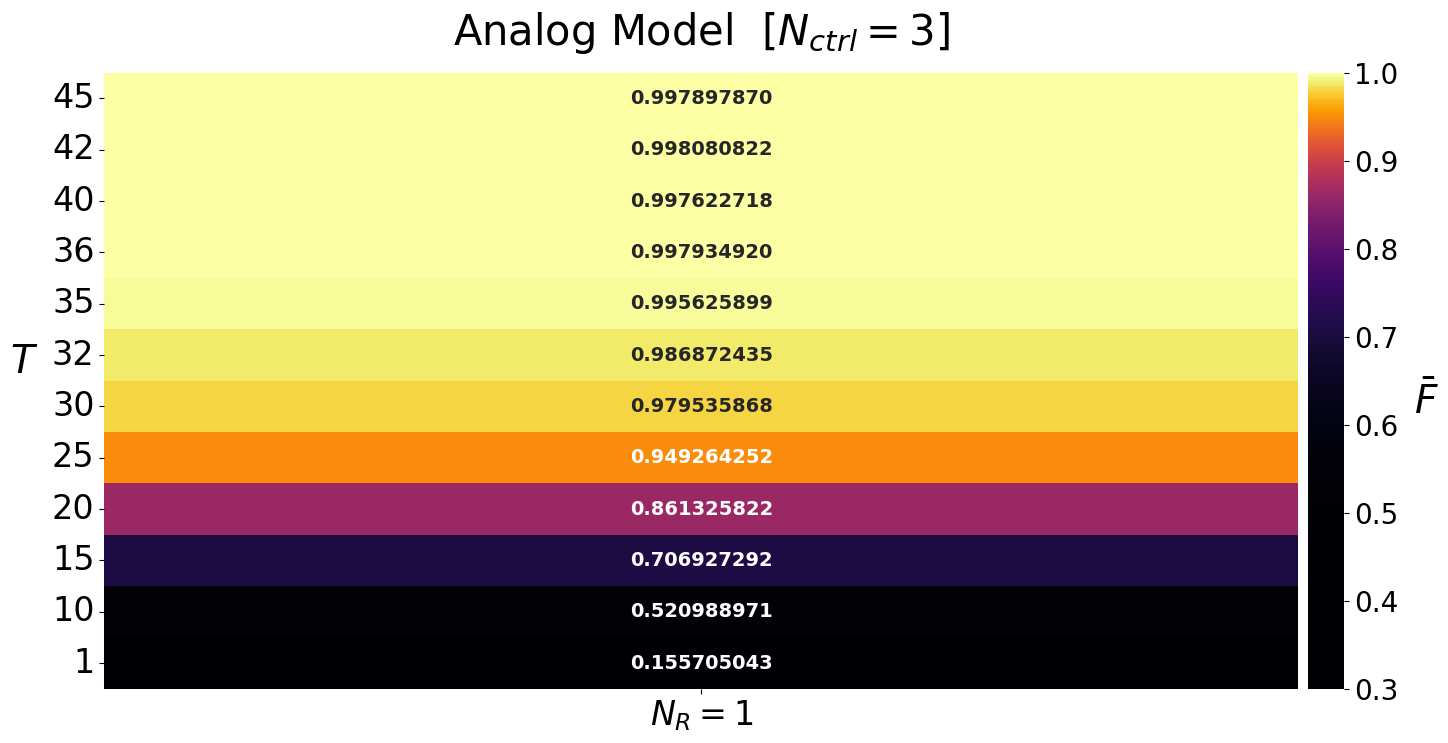

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots =[1, 2,3,4,5, 6,7, 8,9, 10, 12, 14, 16,18, 20,24]
        
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Average_Fidelity")
    

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.applymap("{:.9f}".format)

    # Define the custom colormap
    values = np.linspace(0, 1, n_colors)**4
    colors = base_colormap(values)
    custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)

    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    # Plot the average fidelity heatmap with annotations
    sns.heatmap(
        pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
        ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
        annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'Analog Model  [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=24, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

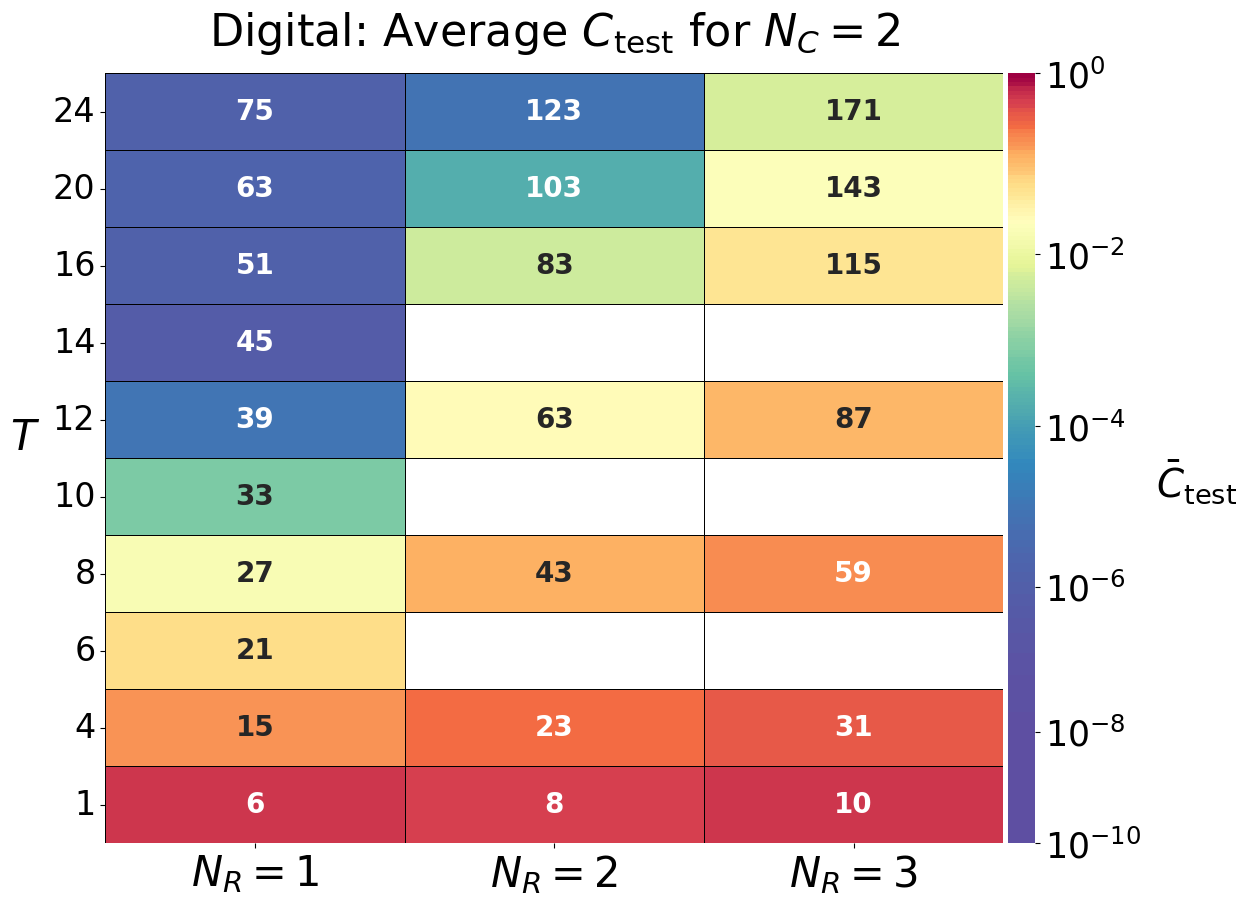

In [37]:
resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24,26]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['N_R'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R', 'N_params']).agg(
        Average_infidelity=('Avg_infidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()
    

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="N_R", values="Avg_Error")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="N_R", values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    # annotation_matrix_avg = pivot_avg.map("{:.1f}".format)
    annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(12, 10))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 20}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    norm=ExaggeratedPowerNorm(gamma=1.2, vmin=-10, vmax=0),  # Custom exaggeration norm
    linewidths=0.5,  # Width of the cell borders
    linecolor="black"  # Color of the borders
    # norm=PowerNorm(gamma=0.8, vmin=-9, vmax=0)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)
    # Set the ticks and labels for the color bar
    ticks = cbar.get_ticks()  # Get current ticks
    cbar.set_ticks(ticks)  # Reset ticks to match current settings
    cbar.set_ticklabels([r"$10^{{{:.0f}}}$".format(t) for t in ticks])  # Set labels as 10^tick

    cbar.set_label(r'$\bar{C}_{\text{test}}$', rotation=0, labelpad=40, fontsize=28, weight='bold')
    cbar.ax.xaxis.set_label_position('top')
    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    ctest_str = r'$C_{\text{test}}$'
    heatmap_ax_avg.set_title(f'Digital: Average {ctest_str} for $N_{{C}} = {N_ctrl}$', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=30, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=30, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

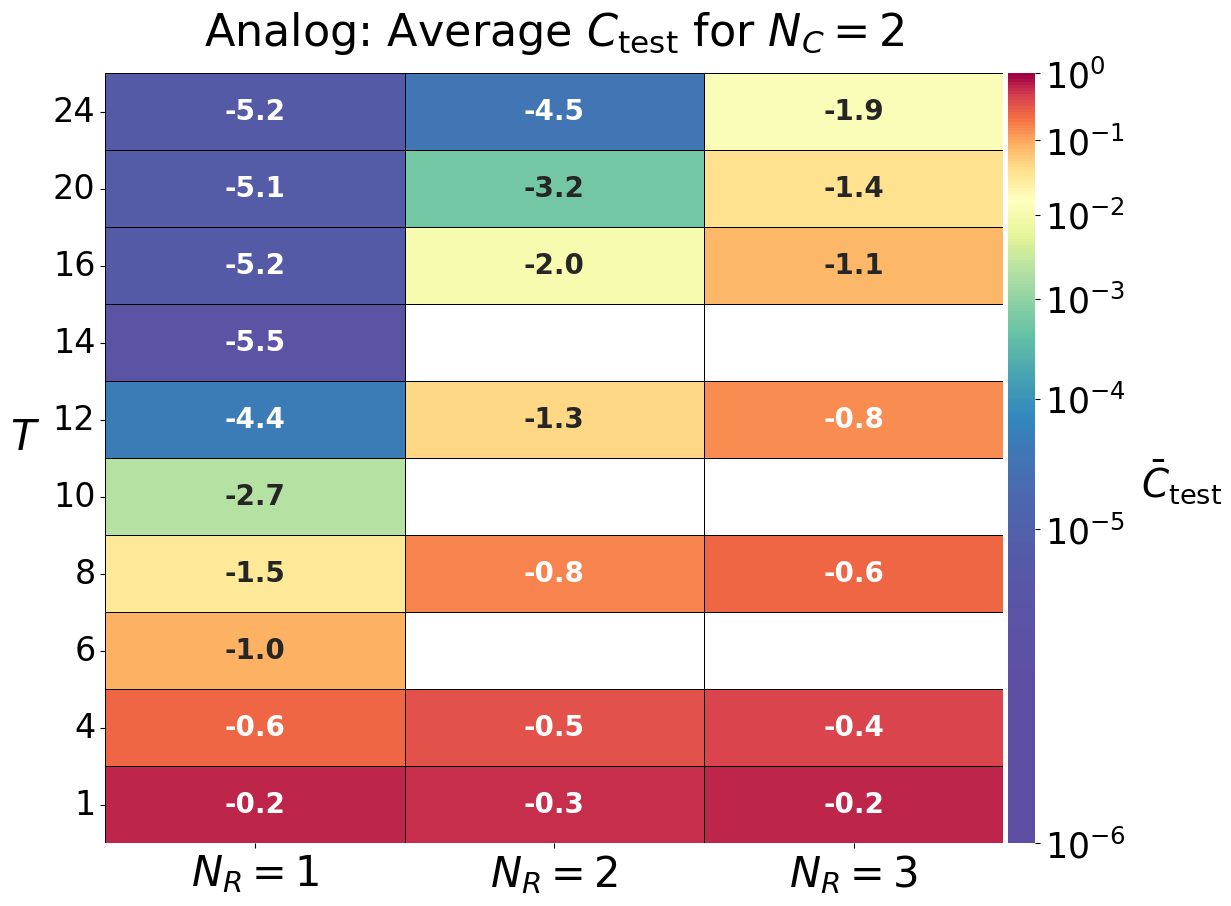

In [36]:
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
class ExaggeratedPowerNorm(Normalize):
    def __init__(self, gamma, vmin=None, vmax=None, clip=False):
        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
        self.gamma = gamma

    def __call__(self, value, clip=None):
        vmin, vmax = self.vmin, self.vmax
        if vmin is None or vmax is None:
            raise ValueError("You must set both vmin and vmax for normalization")
        normalized = (value - vmin) / (vmax - vmin)  # Normalize to [0, 1]
        return normalized ** self.gamma  # Exaggerate higher values


width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

from matplotlib.colors import LinearSegmentedColormap


base_colormap = sns.color_palette("Spectral", as_cmap=True).reversed()

N_ctrls = [2]

resies = [1,2,3,4,5,6]
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24,26]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['N_R'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R', 'N_params']).agg(
        Average_infidelity=('Avg_infidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()
    

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Avg_Error")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.map("{:.1f}".format)
    # annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(12, 10))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 20}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    # norm=ExaggeratedPowerNorm(gamma=1.3, vmin=-6, vmax=0),  # Custom exaggeration norm
    linewidths=0.5,  # Width of the cell borders
    linecolor="black",  # Color of the borders
    norm=PowerNorm(gamma=0.5, vmin=-6, vmax=0)  # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)
    # Set the ticks and labels for the color bar
    ticks = cbar.get_ticks()  # Get current ticks
    cbar.set_ticks(ticks)  # Reset ticks to match current settings
    cbar.set_ticklabels([r"$10^{{{:.0f}}}$".format(t) for t in ticks])  # Set labels as 10^tick

    cbar.set_label(r'$\bar{C}_{\text{test}}$', rotation=0, labelpad=40, fontsize=28, weight='bold')
    cbar.ax.xaxis.set_label_position('top')
    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    ctest_str = r'$C_{\text{test}}$'
    heatmap_ax_avg.set_title(f'Analog: Average {ctest_str} for $N_{{C}} = {N_ctrl}$', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=30, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=30, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

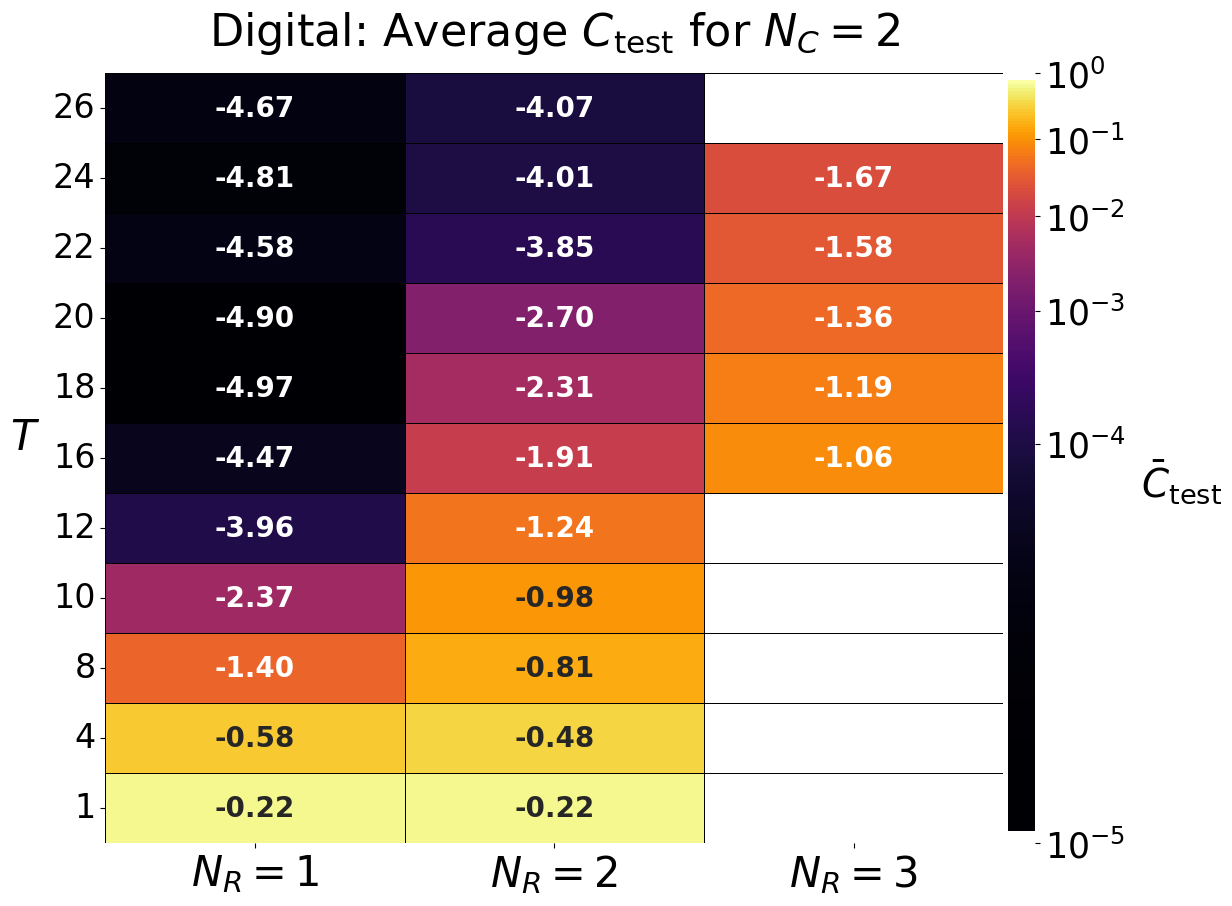

In [17]:
resies = [1,2,3,4,5,6]
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import PowerNorm
for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 17,18,19,20,21,22, 24,26]
        # trots = np.arange(1,50,1)
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))  & (all_data_df['N_R'].isin(resies))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R', 'N_params']).agg(
        Average_infidelity=('Avg_infidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()
    

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Avg_Error")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="N_params")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.map("{:.2f}".format)
    # annotation_matrix_avg = pivot_std.map("{:.0f}".format)

    # Define the custom colormap
    values = np.linspace(global_min_fidelity**2, 1, n_colors)**4
    colors = base_colormap(values)
    # custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)
    custom_colormap = LinearSegmentedColormap.from_list('vibrant', colors, N=n_colors)
    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(12, 10))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Plot the average fidelity heatmap with annotations
    # sns.heatmap(
    #     pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
    #     ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
    #     annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    # )
    sns.heatmap(
    pivot_avg, 
    annot=annotation_matrix_avg, 
    fmt="s", 
    cmap=custom_colormap, 
    ax=heatmap_ax_avg, 
    cbar_ax=cax, 
    cbar_kws={'label': 'Fidelity'}, 
    annot_kws={"weight": "bold", "size": 20}, 
    #  vmin=global_min_fidelity, vmax=global_max_fidelity
    # norm=ExaggeratedPowerNorm(gamma=.5, vmin=-5, vmax=0),  # Custom exaggeration norm
    linewidths=0.5,  # Width of the cell borders
    linecolor="black",  # Color of the borders
    norm=PowerNorm(gamma=.4, vmin=-4.92, vmax=-.1) # Adjust gamma (e.g., 0.5 for more contrast in low range)
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=25)
    # Set the ticks and labels for the color bar
    ticks = cbar.get_ticks()  # Get current ticks
    cbar.set_ticks(ticks)  # Reset ticks to match current settings
    cbar.set_ticklabels([r"$10^{{{:.0f}}}$".format(t) for t in ticks])  # Set labels as 10^tick

    cbar.set_label(r'$\bar{C}_{\text{test}}$', rotation=0, labelpad=40, fontsize=28, weight='bold')
    cbar.ax.xaxis.set_label_position('top')
    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    ctest_str = r'$C_{\text{test}}$'
    heatmap_ax_avg.set_title(f'Digital: Average {ctest_str} for $N_{{C}} = {N_ctrl}$', fontsize=32, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=30, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=30, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_83829/3898999208.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


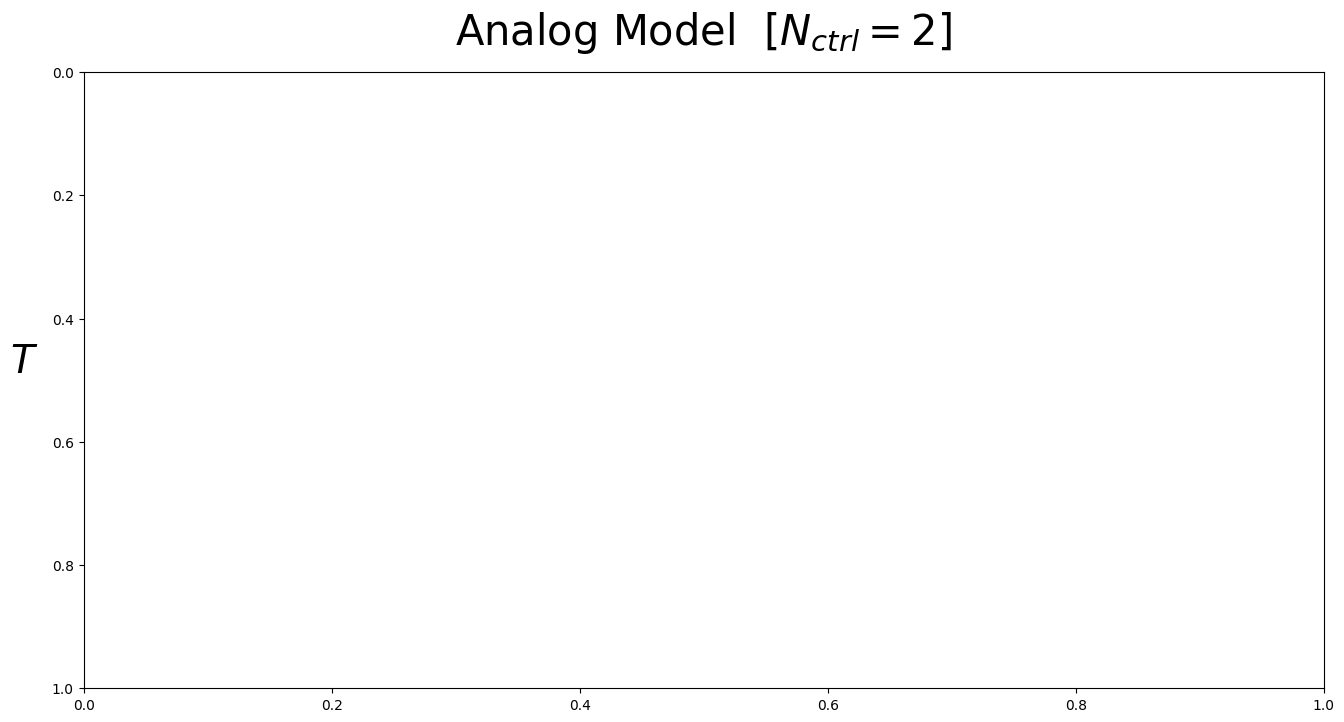

In [18]:
se_colormap = plt.cm.inferno  # Base colormap for visual appeal

for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots =[1, 4, 6, 8, 10, 12, 14, 16,18, 20,24]
        
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Avg_Error=('Avg Error', 'mean')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Avg_Error")
    

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)

    # Define the custom colormap
    values = np.linspace(0, 1, n_colors)**4
    colors = base_colormap(values)
    custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)

    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    # Plot the average fidelity heatmap with annotations
    sns.heatmap(
        pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
        ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
        annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    axs.invert_yaxis()
    axs.set_title(f'Analog Model  [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
    axs.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=24, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

  

    

    plt.show()

   Trotter_Step  Error_Test_Results
0            12           -1.689432
0            12           -1.253193
0            12           -1.498322
0            12           -1.180775
0            12           -1.473097


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_83829/4252819927.py:22: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxenplot(


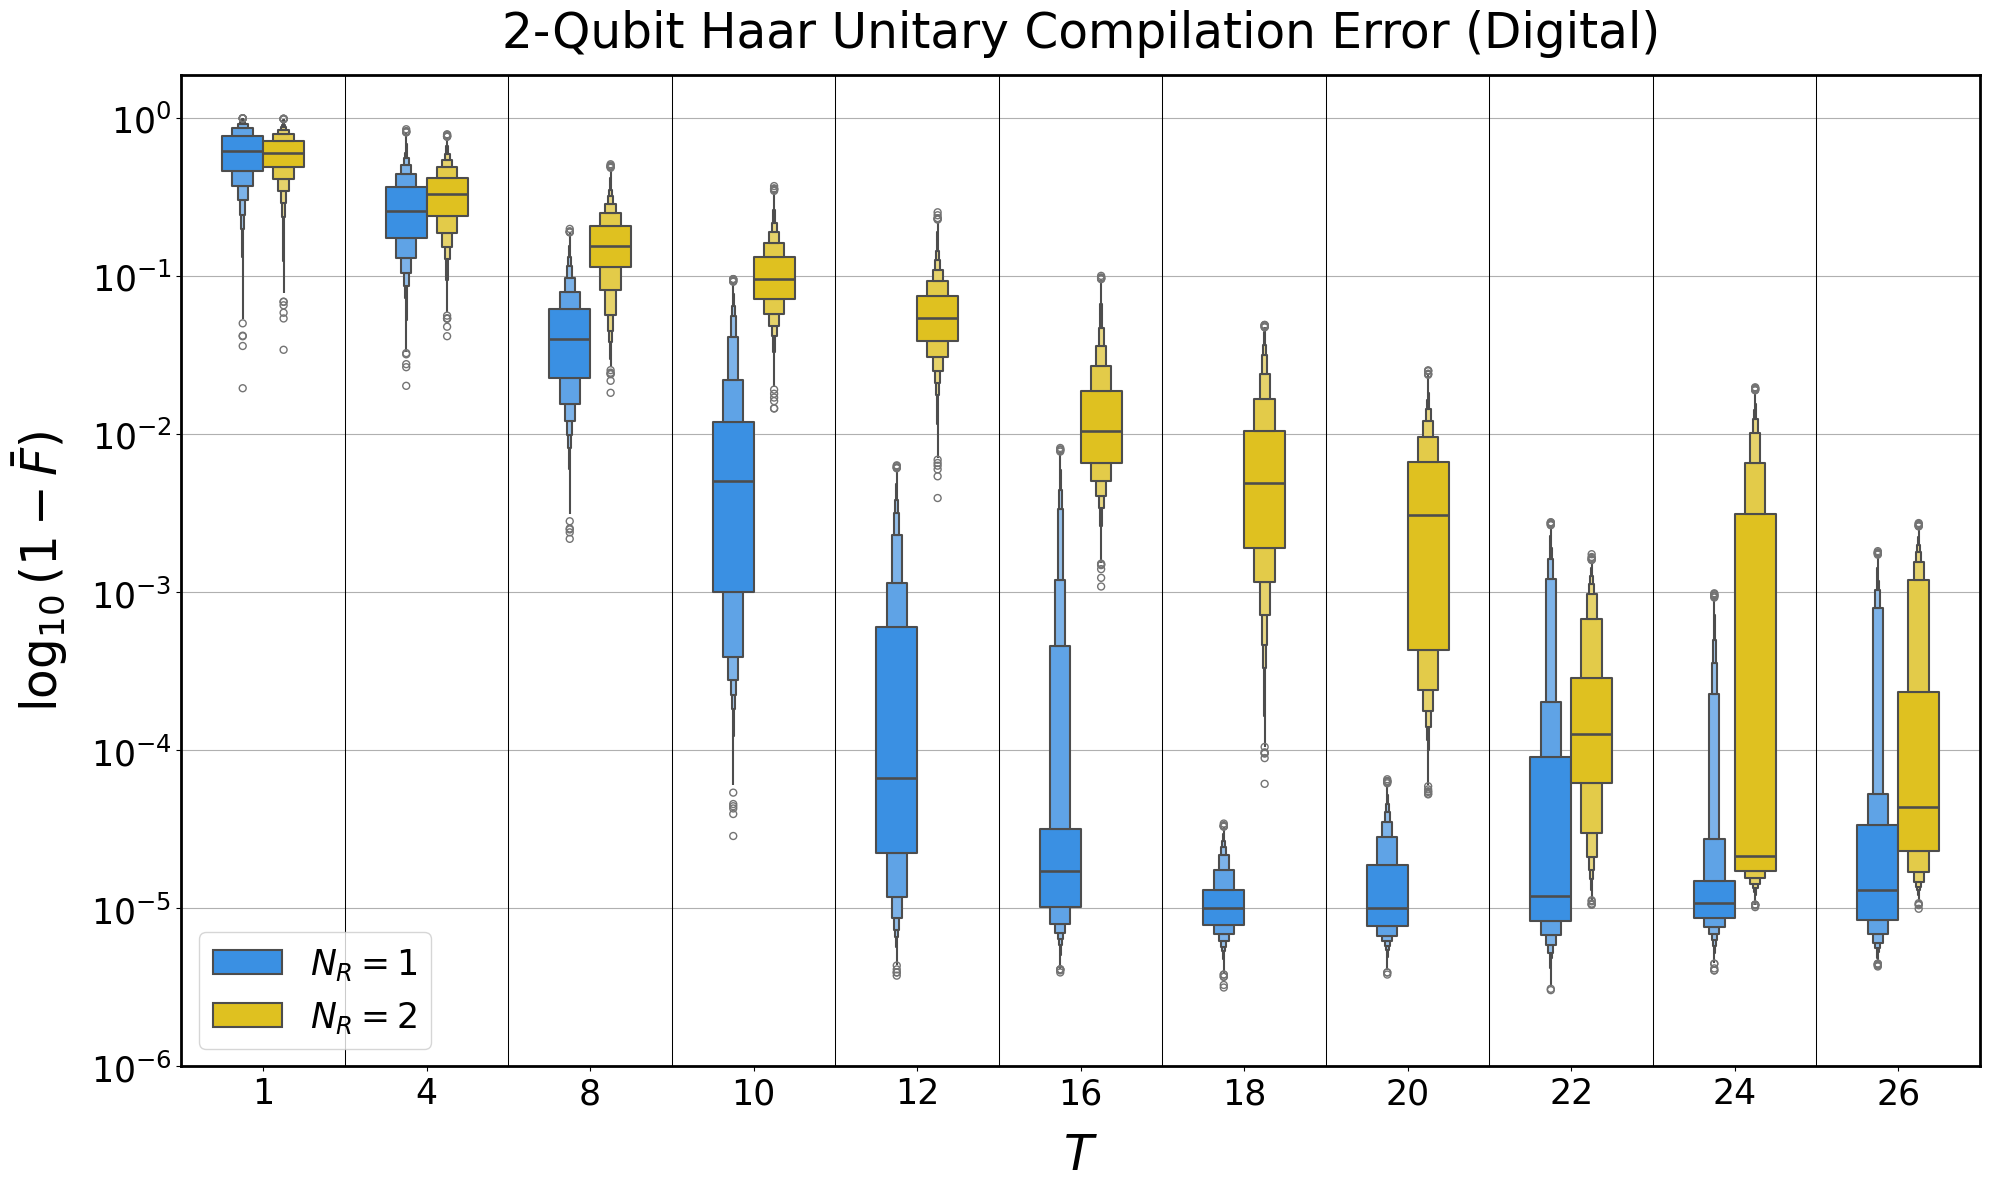

In [19]:
# Ensure that 'Error_Test_Results' is exploded properly
if isinstance(test_results_df['Error_Test_Results'].iloc[0], list):
    test_results_df = test_results_df.explode('Error_Test_Results', ignore_index=True)

# Ensure 'Error_Test_Results' is numeric
test_results_df['Error_Test_Results'] = pd.to_numeric(test_results_df['Error_Test_Results'], errors='coerce')

# Drop rows with NaN values in 'Error_Test_Results'
test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

# Recheck the DataFrame
print(test_results_df[['Trotter_Step', 'Error_Test_Results']].head())

# Proceed with the boxenplot
fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Boxenplot for Error_Test_Results (log10(1 - Test Results))
sns.boxenplot(
    x='Trotter_Step',
    y='Error_Test_Results',
    hue='N_R',
    data=test_results_df,
    ax=axs,
    palette=custom_palette,
    k_depth='tukey',
    linewidth=1.5,
    width_method="exponential",
    width=.5
)

# Set titles and labels with padding
axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)
axs.tick_params(axis='y', labelsize=25)
axs.tick_params(axis='x', labelsize=25)

# Add vertical lines to separate groups
unique_trotter_steps = test_results_df['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)
# Set the global Y-limits
# axs.set_ylim(global_min_y, global_max_y)

# Prevent clipping of y-axis ticks/labels
plt.tight_layout()
plt.show()

Filtering data for N_ctrl=3 and N_R=1...
Calculating median and IQR...


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_92092/800492185.py:280: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


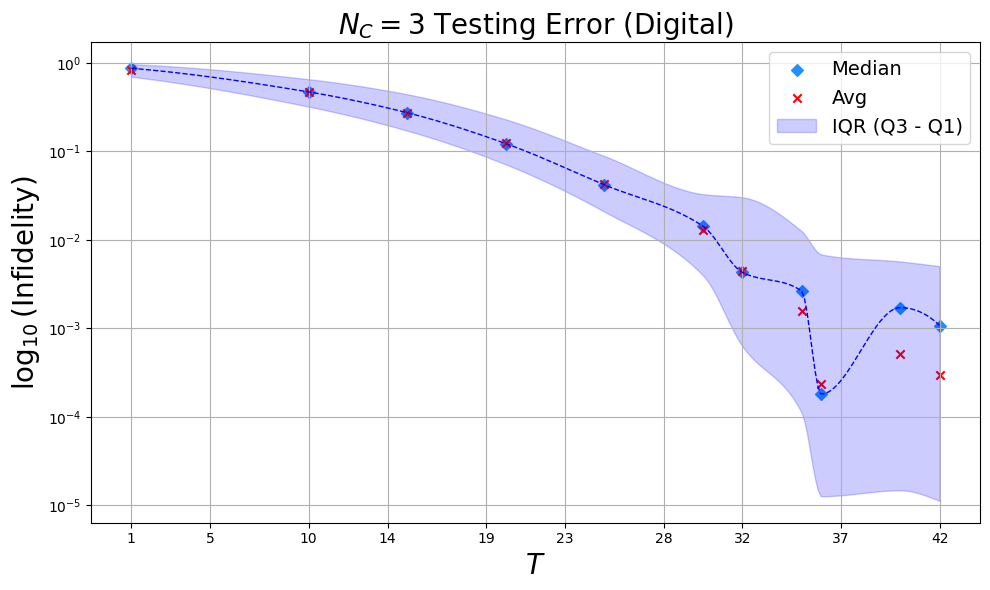

Filtering data for N_ctrl=2 and N_R=1...
Calculating median and IQR...


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_92092/800492185.py:391: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


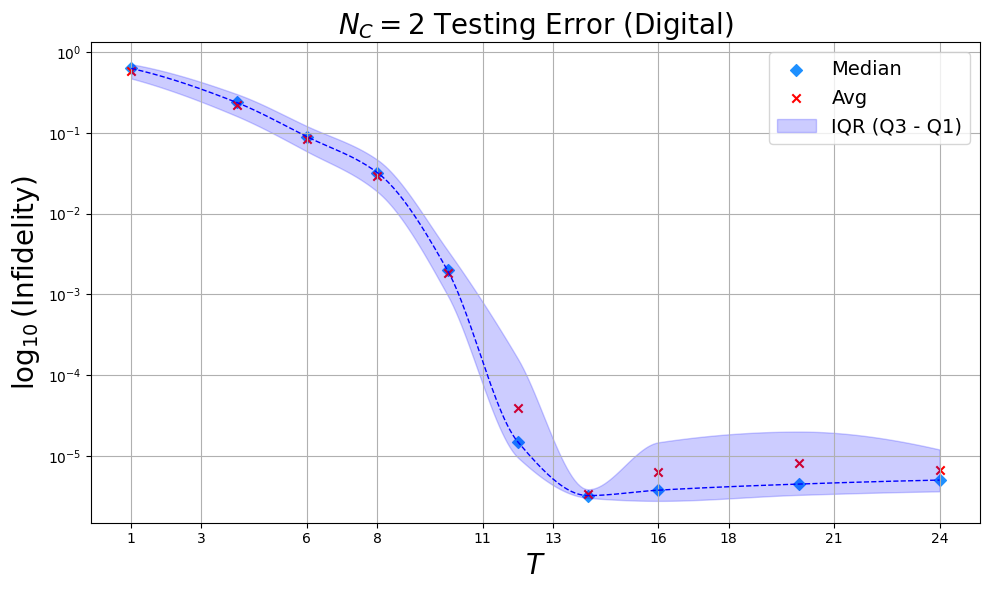

In [43]:
def plot_error_with_iqr_averaged(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    """
    Plot error statistics using the median and IQR for averaged fidelity per gate.
    """

    # Filter the DataFrame for specific N_ctrl and N_R
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Explode the list of infidelities into individual rows
    print("Exploding averaged infidelities into individual rows...")
    exploded_df = filtered_df.explode('Avg_infidelity').reset_index()

    # Ensure that the exploded column contains only numeric data
    exploded_df['Avg_infidelity'] = pd.to_numeric(exploded_df['Avg_infidelity'], errors='coerce')

    # Calculate median and IQR for each Trotter step
    print("Calculating median and IQR...")
    stats = exploded_df.groupby('Trotter_Step')['Avg_infidelity'].agg(
        median=np.median,
        q1=lambda x: np.percentile(x, 25),  # 25th percentile
        q3=lambda x: np.percentile(x, 75)   # 75th percentile
    ).reset_index()

    # Compute the bounds
    stats['lower_bound'] = stats['q1']  # Lower bound = Q1 (25th percentile)
    stats['upper_bound'] = stats['q3']  # Upper bound = Q3 (75th percentile)

    # Print the statistics
    print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    for _, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, Q1: {row['lower_bound']}, Q3: {row['upper_bound']}")

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound'], 
        label='Lower Bound (Q1)', 
        linestyle='--', 
        color='red'
    )

    # Plot the upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound'], 
        label='Upper Bound (Q3)', 
        linestyle='--', 
        color='red'
    )

    # Plot the shaded region (IQR)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound'],
        stats['upper_bound'],
        color='dodgerblue',
        alpha=0.2,
        label='IQR (Q3 - Q1)'
    )

    # Customize the plot
    
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()

def compute_error_statistics(data_df, metric):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')[metric]  
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna() 
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 30)  # 25th percentile
            q3 = np.percentile(exploded_values, 70)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

def weighted_moving_average(values, window=3):
    """
    Compute a weighted moving average to smooth data.
    
    Args:
        values (array-like): Array of values to smooth.
        window (int): Size of the moving window.
    
    Returns:
        np.array: Smoothed values.
    """
    weights = np.arange(1, window + 1)  # Linear weights
    smoothed = np.convolve(values, weights / weights.sum(), mode='same')
    return smoothed

def plot_error_with_metric(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric='Total_Avg_Infidelity', std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the specified metrics.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', midpoint_metric, and std_metric.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): N_R to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Filter the DataFrame for specific N_ctrl and N_R
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
        lambda x: np.concatenate(x) if isinstance(x, list) else x
    )

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    # stats = (
    #     filtered_df.groupby('Trotter_Step', group_keys=False)
    #     .apply(lambda group: pd.Series({
    #         'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
    #         'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
    #         'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 75)   # Q3 from std_metric
    #     }))
    #     .reset_index()
    # )
    stats_list = []

    # Group by Trotter_Step
    for trotter_step, group in filtered_df.groupby('Trotter_Step'):
        # print(f"Processing Trotter Step: {trotter_step}")
        # print(f"Midpoint Metric Value: {group[midpoint_metric].iloc[0]}")

        # Extract the single value for the median
        median_value = group[midpoint_metric].iloc[0]  # Single value per group

        # Flatten the std_metric column for this group
        flattened_std_metric = np.concatenate(group[std_metric].values)
        # print(f"Flattened Std Metric: {flattened_std_metric}")

        # Calculate lower and upper bounds
        lower_bound = np.percentile(flattened_std_metric, 10)
        upper_bound = np.percentile(flattened_std_metric, 80)
        lower_bound2 = median_value-np.std(flattened_std_metric)/2
        upper_bound2 = median_value+np.std(flattened_std_metric, ddof=1)/2


        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Lower Bound: {lower_bound2}, Upper Bound: {upper_bound2}\n")
        # Append the results as a dictionary
        stats_list.append({
            'Trotter_Step': trotter_step,
            'median': median_value,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

    # Convert the list of dictionaries into a DataFrame
    stats = pd.DataFrame(stats_list)

    # Print statistics for verification
    print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    for _, row in stats.iterrows():
        print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']:.1e}, Q1: {row['lower_bound']:.1e}, Q3: {row['upper_bound']:.1e}")

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot the median line
    plt.plot(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the lower bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['lower_bound'], 
        label='Lower Bound (Q1)', 
        linestyle='--', 
        color='red'
    )

    # Plot the upper bound as a red line
    plt.plot(
        stats['Trotter_Step'], stats['upper_bound'], 
        label='Upper Bound (Q3)', 
        linestyle='--', 
        color='red'
    )

    # Plot the shaded region (IQR)
    plt.fill_between(
        stats['Trotter_Step'],
        stats['lower_bound'],
        stats['upper_bound'],
        color='dodgerblue',
        alpha=0.2,
        label='IQR (Q3 - Q1)'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    print("Displaying plot...")
    plt.show()

from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator
def plot_error_with_smoothed_bands(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): N_R to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and N_R
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'lower_bound': np.percentile(np.concatenate(group[std_metric].values), 10),  # Q1 from std_metric
            'upper_bound': np.percentile(np.concatenate(group[std_metric].values), 90),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'std': np.std(np.concatenate(group[std_metric].values))   # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
    # pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    # pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    # pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
def plot_error_with_smoothed_bands_std(data_df, N_ctrl, N_R, xlabel, ylabel, title, midpoint_metric = 'Total_Avg_Infidelity',std_metric='Error_Test_Results'):
    """
    Plot error statistics using the median and IQR for the existing 'Avg Error' column.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'Avg Error', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): N_R to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
    """


    # Filter the DataFrame for specific N_ctrl and N_R
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)].copy()

    # Flatten the std_metric column if it contains lists
    # Flatten the std_metric column if it contains lists
    if std_metric in ['Error_Test_Results', 'infidelities']:
        # For list-based metrics, flatten using np.concatenate
        filtered_df.loc[:, std_metric] = filtered_df[std_metric].apply(
            lambda x: np.concatenate(x) if isinstance(x, list) else x
        )
    elif std_metric in ['Avg Error', 'Avg_infidelity']:
        # For scalar metrics, no flattening is needed
        filtered_df.loc[:, std_metric] = filtered_df[std_metric]
    else:
        raise ValueError(f"Unexpected std_metric: {std_metric}")

    # Ensure there are no NaNs in the std_metric column
    if filtered_df[std_metric].isna().any():
        raise ValueError("NaN values detected in the specified std_metric column! Check the data preprocessing step.")
    
    # Group by 'Trotter_Step' and calculate statistics
    print("Calculating median and IQR...")
    stats = (
        filtered_df.groupby('Trotter_Step', group_keys=False)
        .apply(lambda group: pd.Series({
            # 'median': group[midpoint_metric].iloc[0],  # Median is already a single value per group
             'median': np.median(np.concatenate(group[std_metric].values)), 
              
            'q1': np.percentile(np.concatenate(group[std_metric].values), 25),  # Q1 from std_metric
            'q3': np.percentile(np.concatenate(group[std_metric].values), 75),   # Q3 from std_metric
            'avg': np.mean(np.concatenate(group[std_metric].values)),   # Q3 from std_metric
            'lower_bound':np.mean(np.concatenate(group[std_metric].values))- np.std(np.concatenate(group[std_metric].values))/2,   # Q3 from std_metric
            'upper_bound':np.mean(np.concatenate(group[std_metric].values))+ np.std(np.concatenate(group[std_metric].values))/2 # Q3 from std_metric
        }))
        .reset_index()
    )
    
    # Print statistics for verification
    # print("\nTrotter Step | Median | Q1 (Lower Bound) | Q3 (Upper Bound)")
    # for _, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']} | Median: {row['median']:.1e} | Mean: {row['avg']:.1e} | Q3-Q1: {abs(row['upper_bound']) - abs(row['lower_bound']):.2e} ")

    pchip_median = PchipInterpolator(stats['Trotter_Step'], stats['median'])
    # pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    # pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])
    pchip_mean = PchipInterpolator(stats['Trotter_Step'], stats['avg'])
    pchip_lower = PchipInterpolator(stats['Trotter_Step'], stats['lower_bound'])
    pchip_upper = PchipInterpolator(stats['Trotter_Step'], stats['upper_bound'])

    # Generate fine-grained x-axis for smooth plotting
    x_fine = np.linspace(stats['Trotter_Step'].min(), stats['Trotter_Step'].max(), 300)

    # Evaluate the PCHIP interpolators
    median_smooth = pchip_median(x_fine)
    lower_smooth = pchip_lower(x_fine)
    upper_smooth = pchip_upper(x_fine)


    # # Evaluate the splines
    # median_smooth = spline_median(x_fine)
    # lower_smooth = spline_lower(x_fine)
    # upper_smooth = spline_upper(x_fine)

    # Plot the splines
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_fine, median_smooth,linestyle='--',lw=1, color='blue')
    plt.scatter(
        stats['Trotter_Step'], stats['median'], 
        label='Median', 
        marker='D', 
        color='dodgerblue'
    )
    plt.scatter(stats['Trotter_Step'], stats['avg'], label='Avg', marker='x', color='red')
    # plt.plot(x_fine, upper_smooth, label='Smoothed Upper Bound (Q3)', linestyle='--', color='red')
    plt.fill_between(x_fine, lower_smooth, upper_smooth, color='blue', alpha=0.2,label='IQR (Q3 - Q1)')
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    num_ticks = 10  # Adjust this for more or fewer ticks
    x_ticks = np.linspace(min(stats['Trotter_Step']), max(stats['Trotter_Step']), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize the plot
    plt.xlabel('$T$', fontsize=20)
    plt.ylabel(r'$\log_{10}\left(\text{Infidelity}\right)$', fontsize=20)
    plt.title(f"$N_C={N_ctrl}$ Testing Error (Digital)", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'N_R', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: np.concatenate(x.values),  # Flatten infidelities
        'Error_Test_Results': lambda x: np.concatenate(x.values),  # Flatten test results
         'Avg_infidelity': list,  # Aggregate floats into a list
        'Avg Error': list,  # Aggregate floats into a list
    })
    .reset_index()
)

# print(aggregated_data)

aggregated_data['Total_Avg_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Total_Avg_Infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.mean(res)
)
aggregated_data['Median_Error'] = aggregated_data['Error_Test_Results'].apply(
    lambda res: np.median(res)
)
aggregated_data['Median_infidelity'] = aggregated_data['infidelities'].apply(
    lambda res: np.median(res)
)
# print(aggregated_data.head())

plot_error_with_smoothed_bands(
    data_df=aggregated_data,
    N_ctrl=3,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Error_Test_Results',
    # midpoint_metric = 'Total_Avg_Error',
    std_metric = 'Error_Test_Results'
)
plot_error_with_smoothed_bands_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and IQR of Compilation Error vs Trotter Steps',
    midpoint_metric = 'Avg Error',
    std_metric = 'Error_Test_Results'
)

Filtering data for N_ctrl=2 and N_R=1...
Exploding 'infidelities' column into individual rows and computing log infidelities...
Calculating median and confidence intervals in log scale...



n_params: [6, 15, 21, 27, 33, 39, 45, 51, 63, 75]
Plotting the data...


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_92092/1309089213.py:158: FutureWarning: The provided callable <function median at 0x10e06ef20> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  stats = exploded_df.groupby('N_params')['log_infidelities'].agg(


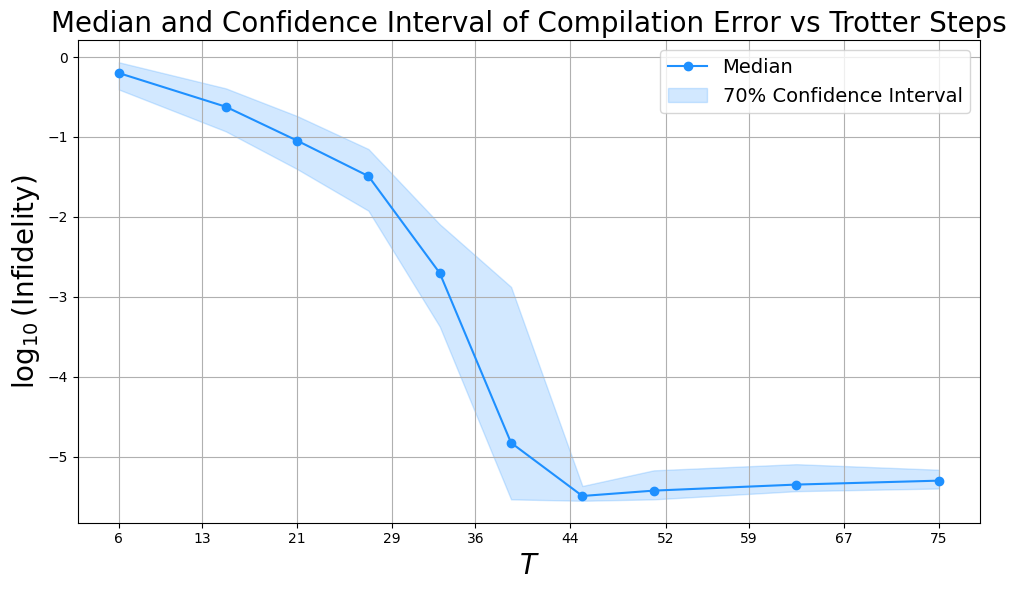

[1, 4, 6, 8, 10, 12, 14, 16, 20, 24]


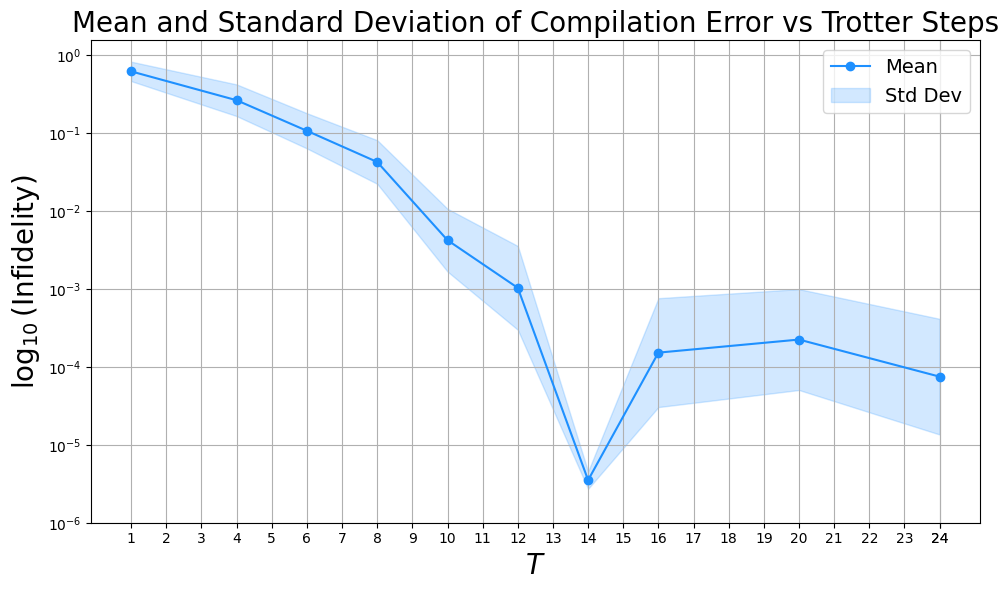

In [39]:
# Function to compute median and IQR for each Trotter step
def compute_error_statistics(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            median = np.median(exploded_values)
            q1 = np.percentile(exploded_values, 10)  # 25th percentile
            q3 = np.percentile(exploded_values, 90)  # 75th percentile
            statistics[trotter_step] = (median, q1, q3)
    return statistics

# Function to compute mean and standard deviation for each Trotter step
def compute_error_statistics_std(data_df):
    statistics = {}
    grouped = data_df.groupby('Trotter_Step')['infidelities']  # Use 'infidelities' column in linear scale
    for trotter_step, values in grouped:
        exploded_values = values.explode().dropna()  # Explode lists into individual values
        if not exploded_values.empty:
            mean = np.mean(exploded_values)
            std = np.std(exploded_values)
            statistics[trotter_step] = (mean, std)
    return statistics
def plot_error_with_iqr(data_df, N_ctrl,N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl
    # filtered_df = data_df[data_df['N_C'] == N_ctrl]
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    print(trotter_steps)
    medians = [np.log10(median) for median, _, _ in statistics.values()]
    q1 = [np.log10(q1) for _, q1, _ in statistics.values()]
    q3 = [np.log10(q3) for _, _, q3 in statistics.values()]

    # Plot median and IQR
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, medians, label='Median', marker='o', color='dodgerblue')
    axs.fill_between(trotter_steps, q1, q3, color='dodgerblue', alpha=0.2, label='IQR (Q3 - Q1)')
    # num_ticks = 10  # Adjust this for more or fewer ticks
    num_ticks = len(trotter_steps)
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num_ticks, dtype=int)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])
    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=16)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()

def plot_error_with_std(data_df, N_ctrl, N_R, xlabel, ylabel, title):
    # Filter data for the specific N_ctrl and N_R
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Compute statistics (in linear scale)
    statistics = compute_error_statistics_std(filtered_df)

    # Prepare data for plotting (apply log scale after)
    trotter_steps = sorted(statistics.keys())
    print(trotter_steps)
    means = [np.log10(mean) for mean, _ in statistics.values()]
    std_devs = [np.log10(mean + std) - np.log10(mean) for mean, std in statistics.values()]

    # Plot mean and standard deviation
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.plot(trotter_steps, means, label='Mean', marker='o', color='dodgerblue')
    axs.fill_between(
        trotter_steps,
        np.array(means) - np.array(std_devs),
        np.array(means) + np.array(std_devs),
        color='dodgerblue',
        alpha=0.2,
        label='Std Dev'
    )

    # Customize x-axis ticks
    num_ticks = len(trotter_steps)
    # x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), 2, dtype=int)
    x_ticks = np.arange(min(trotter_steps),  max(trotter_steps)+2, 1)
    x_ticks[-1] = max(trotter_steps)
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    # Customize y-axis ticks with scientific notation
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    if whole_y_ticks:
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Add labels and title
    axs.set_xlabel(xlabel, fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_title(title, fontsize=20)
    axs.legend(fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=10)  # Larger tick labels
    axs.grid(True)

    plt.tight_layout()
    plt.show()
def plot_error_with_precomputed_log(data_df, N_ctrl, N_R, xlabel, ylabel, title, confidence=0.50):
    """
    Plot error statistics with precomputed log-transformed infidelities.
    Median and percentile-based confidence intervals are calculated directly in log scale.
    
    Args:
        data_df (pd.DataFrame): DataFrame containing 'Trotter_Step', 'log_infidelities', etc.
        N_ctrl (int): Number of control qubits to filter.
        N_R (int): N_R to filter.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str): Title of the plot.
        confidence (float): Confidence level for the interval (default: 0.50).
    """
    # Filter the DataFrame for specific N_ctrl and N_R
    print(f"Filtering data for N_ctrl={N_ctrl} and N_R={N_R}...")
    filtered_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['N_R'] == N_R)]

    # Ensure there are no NaNs in the 'log_infidelities' column
    if filtered_df['infidelities'].isna().any():
        raise ValueError("NaN values detected in the 'infidelities' column! Check the data preprocessing step.")

    # Explode the 'infidelities' and precompute log infidelities
    print("Exploding 'infidelities' column into individual rows and computing log infidelities...")
    exploded_df = filtered_df.explode('infidelities').reset_index()
    exploded_df['infidelities'] = pd.to_numeric(exploded_df['infidelities'], errors='coerce')
    exploded_df['log_infidelities'] = np.log10(exploded_df['infidelities'])

    # Percentiles for the confidence interval
    confidence_level = confidence
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100

    # Calculate median and confidence intervals in log scale
    print("Calculating median and confidence intervals in log scale...")
    stats = exploded_df.groupby('N_params')['log_infidelities'].agg(
        median=np.median,
        ci_lower=lambda x: np.percentile(x, lower_percentile),
        ci_upper=lambda x: np.percentile(x, upper_percentile)
    ).reset_index()
    n_params = sorted(stats['N_params'])
    num_ticks = len(n_params)
    x_ticks = np.linspace(min(n_params), max(n_params), num_ticks, dtype=int)
    

    print(f"\n\n\nn_params: {n_params}")
    # Print values for each Trotter step
    # print("\nTrotter Step | Median (Log) | CI Lower (Log) | CI Upper (Log)")
    # for i, row in stats.iterrows():
    #     print(f"Trotter Step: {row['Trotter_Step']}, Median: {row['median']}, Q1: {row['ci_lower']}, Q3: {row['ci_upper']}")

    #     print(f"{row['Trotter_Step']:>12} | {row['median']:<10.6f} | {row['ci_lower']:<10.6f} | {row['ci_upper']:<10.6f}")

    # Plotting
    print("Plotting the data...")
    
    fig, axs = plt.subplots(figsize=(10, 6))
    axs.set_xticks(x_ticks)
    axs.set_xticklabels([str(tick) for tick in x_ticks])

    # Plot the median line with markers
    plt.plot(
        stats['N_params'], stats['median'], 
        label='Median', 
        marker='o', 
        color='dodgerblue'
    )

    # Plot the shaded region for confidence intervals
    plt.fill_between(
        stats['N_params'],
        stats['ci_lower'],
        stats['ci_upper'],
        color='dodgerblue',
        alpha=0.2,
        label=f'{int(confidence_level * 100)}% Confidence Interval'
    )

    # Customize the plot
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)  # Add grid lines
    plt.tight_layout()

    # Show the plot
    plt.show()
aggregated_data = (
    all_data_df
    .groupby(['Trotter_Step', 'N_R', 'N_C', 'N_params'])
    .agg({
        'infidelities': lambda x: sum(x, []),  # Combine lists of infidelities
        'Error_Test_Results': lambda x: sum(x, []),  # Combine test results
    })
    .reset_index()
)

plot_error_with_precomputed_log(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Median and Confidence Interval of Compilation Error vs Trotter Steps',
    confidence=0.70  # 50% confidence interval
)
# # Example Usage:
plot_error_with_std(
    data_df=aggregated_data,
    N_ctrl=2,
    N_R=1,
    xlabel='$T$', 
    ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
    title='Mean and Standard Deviation of Compilation Error vs Trotter Steps'
)


# # Example Usage:
# # Replace `N_ctrl` with the specific control qubit count you want to plot
# plot_error_with_iqr(
#     data_df=aggregated_data,
#     N_ctrl=2,
#     N_R = 1,
#     xlabel='$T$', 
#     ylabel=r'$\log_{10}\left(\text{Infidelity}\right)$', 
#     title='Median and IQR of Compilation Error vs Trotter Steps'
# )


In [20]:
all_data_df.keys()

Index(['N_C', 'Trotter_Step', 'Gate', 'Reservoir Count', 'Avg_Fidelity',
       'Avg_infidelity', 'Error_Test_Results', 'Avg Error', 'infidelities',
       'Costs', 'Test Results', 'N_params', 'run'],
      dtype='object')

In [8]:
def get_n_params(type_model, Nr, steps, Nc):
    # print(type_model)
    if type_model:  # Analog model
        return steps * Nr * Nc + steps +3
    else:  # Digital model
        return steps * Nr * Nc+3
    
def get_df(data_i, trots, type_model, Nc):
    
    infidelity_data = {}
    infidelity_data_averaged = {}
    for gate, gate_data in data_i.items():
        for reservoir_count, trotter_data in gate_data.items():

            for trotter_step, results in trotter_data.items():
                #if not trotter_step in trots:
                #    continue
                infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])

                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                average_fidelity = results['fidelity']
                average_infidelity = 1 - average_fidelity
                # Check if there are invalid infidelities
                # invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                # if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                #     print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                #     print(f"invalid_infidelities: {invalid_infidelities}")
                #     continue
                infidelity_res = 1 - np.array(test_results)
                
                
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
                infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
    all_trotter_steps = sorted(infidelity_data.keys())



    violin_plot_data_all = []
    prev_res = None
    for trotter_step, res_data in infidelity_data.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            log_infidelities = [np.log10(infidelity) if infidelity > 0 else np.log10(prev_res) for infidelity in infidelities]  # Calculate log
            prev_res = np.mean(infidelities)
            violin_plot_data_all.extend([(Nc,trotter_step, reservoir_count, log_inf,inf, n_param) for log_inf, inf in zip(log_infidelities,infidelities)])

    df_violin_all = pd.DataFrame(violin_plot_data_all, columns=['N_C', 'Trots', 'N_R', 'Log(Infidelity)','Infidelity', 'N_param'])

    # Prepare data for violin plot with log(infidelity)
    violin_plot_data_avg = []
    for trotter_step, res_data in infidelity_data_averaged.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            prev_res = np.mean(infidelities)
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else np.log10(prev_res)
                violin_plot_data_avg.append((Nc,trotter_step, reservoir_count, log_infidelity,infidelity, n_param))
                
    df_violin_avg = pd.DataFrame(violin_plot_data_avg, columns=['N_C','Trots', 'N_R', 'Log(Infidelity)','Infidelity', 'N_param'])
    return df_violin_all,df_violin_avg


In [41]:
import pandas as pd
import numpy as np

N_ctrls = [1, 2, 3]
jitter_scale = 1e-10
min_error = 1e-9
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    if N_ctrl in [1,2,3]:

        data_i = cached_data_analog_nctrl3[N_ctrl]
    # elif N_ctrl == 3:
    #     data_i = cached_data_analog_nctrl3[N_ctrl]


    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            if reservoir_count > 1:
                continue
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    log_infidelities = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'N_R': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            if fidelity >= 1.0:
                                fidelity = 1.0 - np.random.uniform(0, jitter_scale)
                            infidelity = max(1.0 - fidelity, min_error)
                            log_infidelity = np.log10(infidelity)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log10(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'N_R': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Error Test Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                    rows.append(row)
# Report any issues found
if negative_fidelity_values:
    print("Negative fidelity values detected!")
    for issue in negative_fidelity_values:
        print(f"Gate: {issue['Gate']}, N_R: {issue['N_R']}, Trotter_Step: {issue['Trotter_Step']}, Fidelity: {issue['Fidelity']}")
else:
    print("No negative fidelity values detected.")
# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)

# Check DataFrame columns to ensure 'N_R' exists
# print("DataFrame Columns:", all_data_df.columns)

# Display a few rows of the DataFrame to inspect
# print(all_data_df.head())

# Filter DataFrame for N_R == 2
# all_data_df = all_data_df[(all_data_df['Trotter_Step'] < 8) & (all_data_df['N_C'] == 2) & (all_data_df['Trotter_Step'] > 1)]

df_U1_6 = all_data_df[all_data_df['N_R'] == 1]
# df_U1_6 = df_U1_6[df_U1_6['Trotter_Step'] == 16]
df_U1_6 = df_U1_6[df_U1_6['N_C'] == 3]
df_U1_6.head()

NameError: name 'cached_data_analog_nctrl3' is not defined

In [40]:
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
# First pass to determine the global min and max y-values across all plots
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16,18, 20,24]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8]
    print(trots)
    trots = np.arange(1,50,1)
    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error Test Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Get min and max y-values for the current N_ctrl
    current_min_y = test_results_df['Error Test Results'].min()
    current_max_y = test_results_df['Error Test Results'].max()

    # Update global min and max y-values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y = 0.3
print(f"global_min_y: {global_min_y}")
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    # if N_ctrl == 2:
    #     trots = [1, 6, 8, 10, 12, 14,16, 20,24]
    # elif N_ctrl == 1:
    #     trots = [1, 2, 3, 4, 5,6,7,8]
    trots = np.arange(1,50,1)

    # Filter the DataFrame for specific N_C (control qubits)
    # data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    # data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    # Filter the DataFrame for specific N_C (control qubits) and Trotter steps
    data_df = all_data_df[all_data_df['N_R'] < 4]
    data_df = data_df[(data_df['N_C'] == N_ctrl) & (data_df['Trotter_Step'].isin(trots))]


    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error Test Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error Test Results (log10(1 - Test Results))
    sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='N_R', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Analog)", fontsize=35, pad=20)

    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower right', fontsize=30, ncol=len(labels))

    # Set the global Y-limits
    axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick-2, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()

[1, 4, 6, 8, 10, 12, 14, 16, 18, 20, 24]


KeyError: 'Error Test Results'

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_29476/2431200628.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


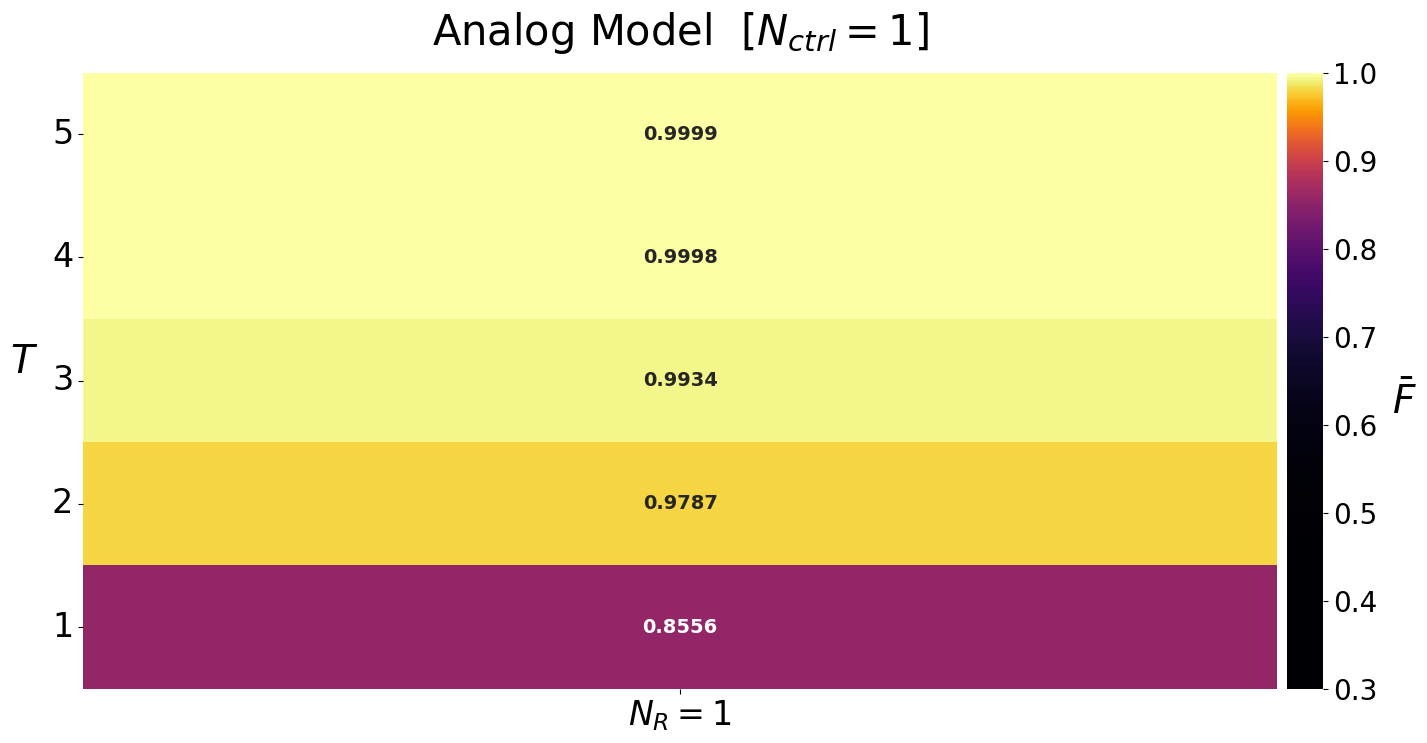

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_29476/2431200628.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


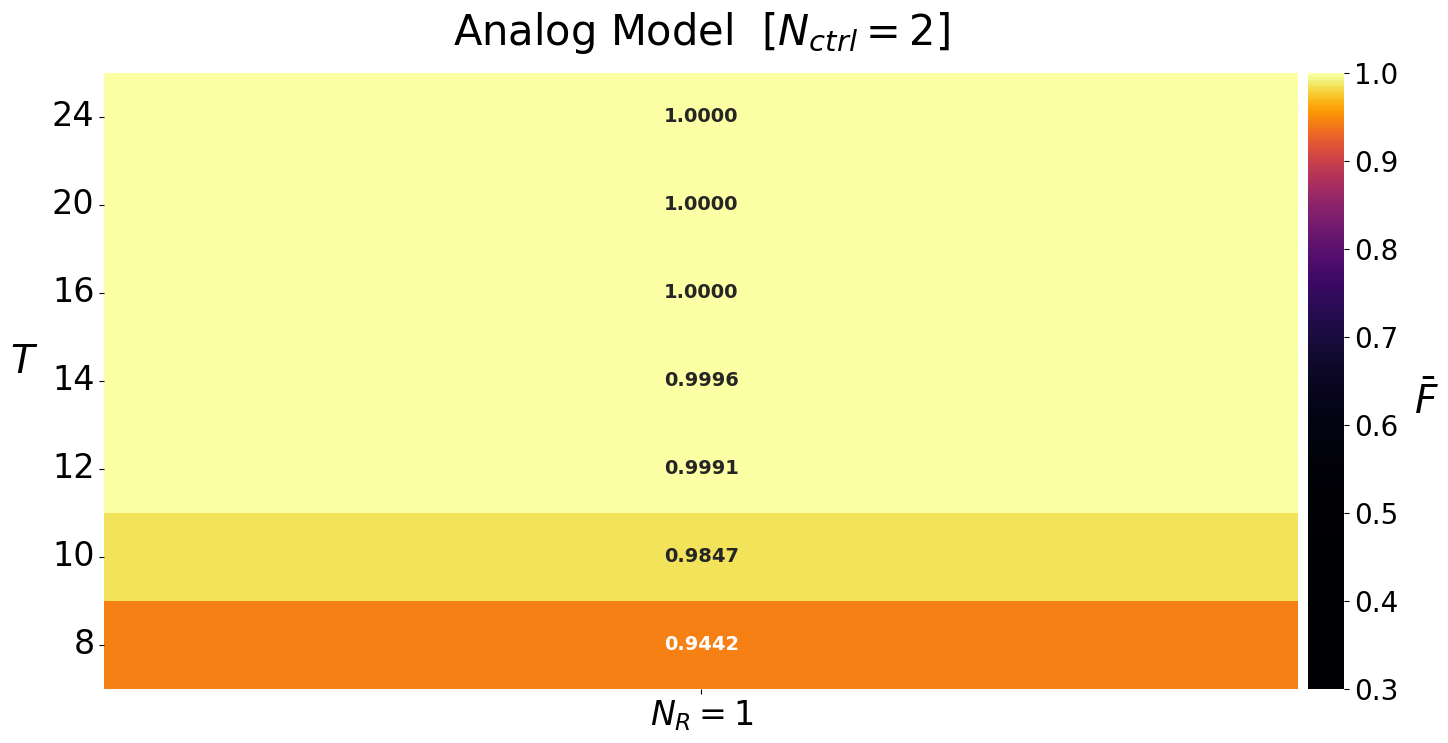

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_29476/2431200628.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


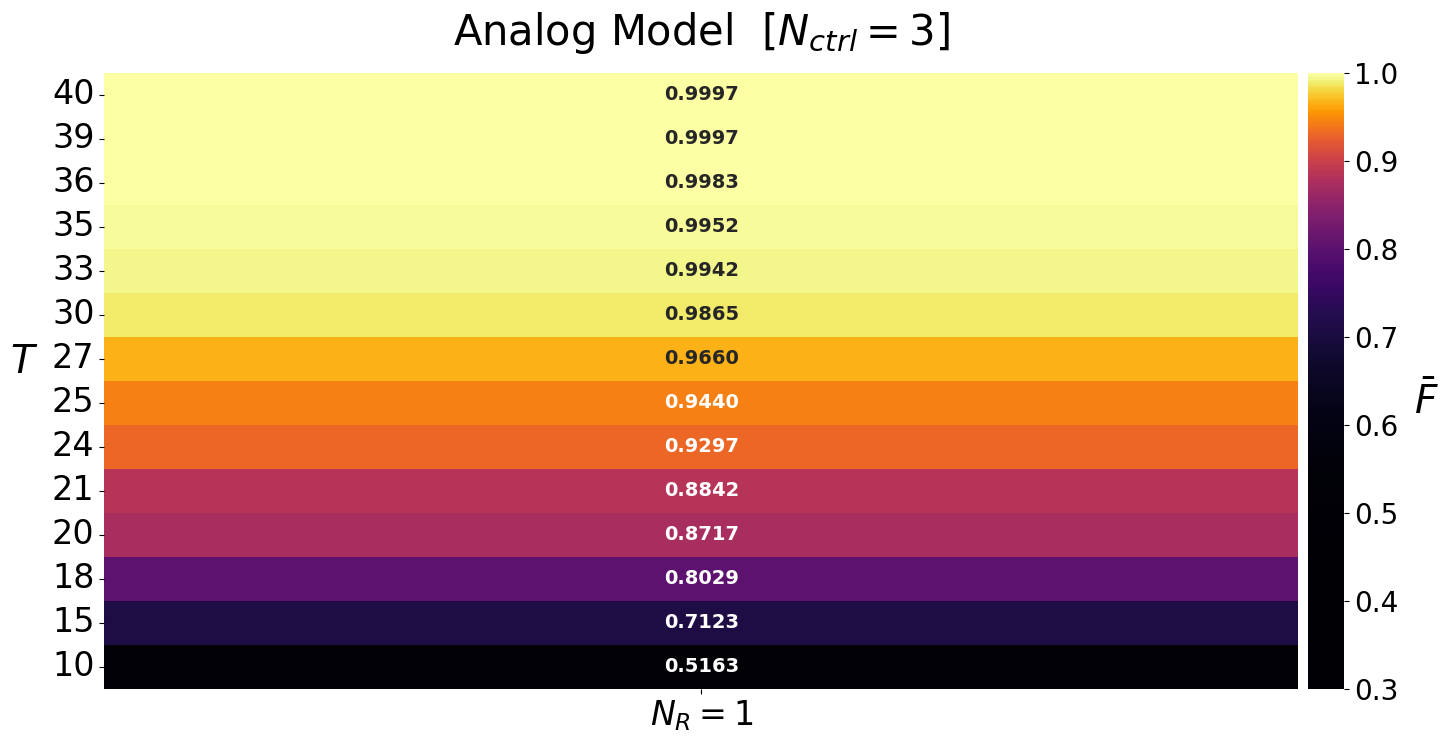

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

for N_ctrl in N_ctrls:
    if N_ctrl == 3:
        trots = np.arange(1,50,1)
    elif N_ctrl == 2:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 20, 24]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5]

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Compute average fidelity and standard deviation for each Trotter step and N_R
    averaged_data = data_df.groupby(['Trotter_Step', 'N_R']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Std_Dev=('Avg_Fidelity', 'std')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Average_Fidelity")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns='N_R', values="Std_Dev")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)

    # Define the custom colormap
    values = np.linspace(0, 1, n_colors)**4
    colors = base_colormap(values)
    custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)

    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    # Plot the average fidelity heatmap with annotations
    sns.heatmap(
        pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
        ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
        annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'Analog Model  [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=24, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Make sure to clear previous figures
plt.close('all')

N_ctrls = [1,2]  # Assuming N_ctrls is a list of control qubits
# all_data_df = all_data_df[all_data_df['Trotter_Step'] < 6]
# all_data_df = all_data_df[all_data_df['N_R'] < 4]
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1,4,6,8,10,12,14,16,18,20,22,24,26,28]
        # trots = [1,2,3,4,5,6,7,8,10,12,14]
    elif N_ctrl == 1:

        trots = [1, 2, 3, 4, 5,6,7,8]


    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    
    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error Test Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error Test Results (log10(1 - Test Results))
    # sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='N_R', data=test_results_df, 
    #                ax=axs, palette=custom_palette,  inner='quartile', saturation=0.75)
    sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='N_R', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile',saturation=0.75)

    # Set titles and labels with padding
    axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_xlabel('$L$ (layers)', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick,max_tick+1,1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25) 
    axs.tick_params(axis='x', labelsize=25) 

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()



In [ ]:
data_df = all_data_df[all_data_df['N_C'] == 1]
# filt_df = data_df[data_df['N_R'] == 2]
filt_df = data_df[(data_df['Trotter_Step'] == 2) & (data_df['N_R'] == 2)]

filt_df.head()

In [ ]:
# Group by 'Gate' and calculate the average fidelity for each gate
avg_fidelity_per_gate = filt_df.groupby('Gate')['Avg_Fidelity'].mean()

# Print the result
for gate, avg_fidelity in avg_fidelity_per_gate.items():
    print(f"Gate: {gate}, Average Fidelity: {avg_fidelity}")

In [ ]:

custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Make sure to clear previous figures
plt.close('all')

trots = [1,2,3,4,5]
N_ctrl = 1
data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
# Filter the DataFrame for specific Trotter_Steps
data_filtered = data_df[data_df['Trotter_Step'].isin(trots)]
data_filtered


In [ ]:

### First Violin Plot for Average Error ###

fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Violin Plot for Average Error (log10(1 - avg_fidelity))
sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered, 
               ax=axs, palette=custom_palette, scale='width', inner="point")

# Set titles and labels with padding
axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=20) 

# Add vertical lines to separate groups
unique_trotter_steps = data_filtered['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

# Show the plot
plt.tight_layout()
plt.show()

### Second Violin Plot for Error Test Results ###

# Explode test results into separate rows to plot each error individually
test_results_df = data_df.explode('Error Test Results')
test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(trots)]

fig, axs = plt.subplots(1, figsize=(20, 12))

# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

# Violin plot for Error Test Results (log10(1 - Test Results))
sns.violinplot(x='Trotter_Step', y='Error Test Results', hue='N_R', data=test_results_df, 
               ax=axs, palette=custom_palette, scale='width', inner='quartile', saturation=0.75)

# Set titles and labels with padding
axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

# Set Y-ticks and labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=25) 
axs.tick_params(axis='x', labelsize=25) 

# Add vertical lines to separate groups
unique_trotter_steps = test_results_df['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black',linewidth=0.75)

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
# Create subplots for visualizing the data
fig, axs = plt.subplots(2, figsize=(14, 18))


# data_average_error = data_df[data_df[]]
# Box plot for fidelity
sns.boxplot(x='Trotter_Step', y='Avg_Fidelity', hue='N_R', data=data_df, ax=axs[0],
            palette='YlOrRd', medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))

# Customize the plot
axs[0].set_title(f'Analog: $\log_{{10}}(1 - F)$', fontsize=25)
axs[0].set_xlabel('$d$ (depth)', fontsize=20)
axs[0].set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)



sns.violinplot(x='Trotter_Step', y='Log_Infidelity', hue='N_R', data=data_df, ax=axs[1],
               palette=custom_palette, scale='width', inner="point", bw_adjust=.4)

# Customize violin plot
axs[1].set_title(f'Analog: $\log_{{10}}(1 - F)$', fontsize=25)
axs[1].set_xlabel('$d$ (depth)', fontsize=20)
axs[1].set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:

fidelity_data = {}
if N_ctrl == 1:

    trots = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
elif N_ctrl == 2:
    trots = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    # trots = [12]
else:
    trots = np.arange(3,54,1)

infidelity_data = {}
infidelity_data_averaged = {}
for gate, gate_data in data_i.items():
    for reservoir_count, trotter_data in gate_data.items():
        if reservoir_count not in reservoir_counts:
            continue
        for trotter_step, results in trotter_data.items():
            if trotter_step not in trots:
                continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                
            average_fidelity = results['fidelity']
            average_infidelity = 1.000 - average_fidelity
            test_results = results['test_results']
            # if trotter_step == 8 and reservoir_count == 2:
            #     print(gate, average_fidelity)
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
            infidelity_res = 1.000 - np.array(test_results)
            # Store infidelities directly
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)           
            infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
# Create subplots for each plot type
fig, axs = plt.subplots(2, figsize=(14, 18)) 

# Prepare data for bar plot
averaged_data = {}
standard_deviation_data = {}
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        if fidelities:
            all_fidelities = np.array(fidelities)
            averaged_data.setdefault(trotter_step, {})[reservoir_count] = np.mean(all_fidelities)
            standard_deviation_data.setdefault(trotter_step, {})[reservoir_count] = np.std(all_fidelities)
  
# Plot bar graph
all_trotter_steps = sorted(averaged_data.keys())
positions = range(len(all_trotter_steps))
offset = -(width * n_groups / 2)
bar_positions = {res_count: [p + offset + idx * width for p in positions] for idx, res_count in enumerate(reservoir_counts)}
y_tickie = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#(reservoir_counts)
# Bar plot
# Prepare data for box plot with parameters on x-axis


box_plot_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        # if reservoir_count != 1 and reservoir_count != 2:
        #     continue
        num_params = trotter_step * N_ctrl * reservoir_count + trotter_step + 3
        for fidelity in fidelities:
            box_plot_data.append((num_params,trotter_step, reservoir_count, float(fidelity)))
df_box_params = pd.DataFrame(box_plot_data, columns=['Number of Parameters', 'time steps','N_R', 'Fidelity'])

# Plot box plot with parameters on x-axis
box_ax_params = axs[0]
sns.boxplot(x='time steps', y='Fidelity', hue='N_R', data=df_box_params, ax=box_ax_params,
            palette='YlOrRd', medianprops={"color": "r", "linewidth": 1}, whis=(5, 95))
for patch in box_ax_params.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
box_ax_params.yaxis.grid(True)
box_ax_params.xaxis.grid(False)
box_ax_params.set_axisbelow(True)
box_ax_params.set_title('Fidelity Distribution (Digital) - Number of Parameters')
box_ax_params.set_xlabel('Number of Parameters')
box_ax_params.set_ylabel('Fidelity')
box_ax_params.legend(title='$N_{R}$')

box_plot_data = []
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        for fidelity in fidelities:
            #print(fidelity)
            box_plot_data.append((trotter_step, reservoir_count, float(fidelity)))


plt.subplots_adjust(hspace=0.5)
   
violin_plot_data = []
for trotter_step, res_data in infidelity_data_averaged.items():
    for reservoir_count, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))
df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'N_R', 'Log(Infidelity)'])
violin_axs = axs[1]
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='N_R', data=df_violin, ax=axs[1],
               palette=custom_palette, scale='width', inner="point", bw_adjust=.4)

# Customize the plot
violin_axs.yaxis.grid(True)
violin_axs.xaxis.grid(False)
violin_axs.set_axisbelow(True)
violin_axs.set_title(f'Analog: $\log_{{10}}(1 - F)$', fontsize=25)
violin_axs.set_xlabel('$d$ (depth)', fontsize=20)
violin_axs.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)

# Customizing the legend
handles, labels = violin_axs.get_legend_handles_labels()
print(handles,labels)
violin_axs.legend(handles, [f'$N_C = {N_ctrl}$, $N_R = {label}$' for label in labels], title_fontsize=16, loc='lower left', fontsize=18)

# Adjust y-tick labels
y_ticks = violin_axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_axs.set_yticks(whole_y_ticks)
violin_axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
violin_axs.tick_params(axis='y', labelsize=16)
violin_axs.tick_params(axis='x', labelsize=16)

# Add vertical lines to separate groups
unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    violin_axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
#violin_axs.set_ylim(-4.3, 0)
# Show the plot
plt.show()

In [ ]:
N_ctrl = 1
data_i = cached_data_analog[N_ctrl]
custom_palette = ['dodgerblue', 'gold', 'violet'] 
reservoir_counts = [1]
width = 0.15  # the width of the bars
n_colors = 256  # number of colors in the colormap
n_groups = len(reservoir_counts)  # number of groups in the bar plot
base_colormap = plt.cm.plasma  # base colormap to use

# Define the colormap
values = np.linspace(0, 1, n_colors)**4  # Raise to a power to skew the distribution
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Initialize global min/max fidelity
global_min_fidelity = float('inf')
global_max_fidelity = 0

# Calculate global min and max fidelity
for gate_data in data_i.values():
    for trotter_data in gate_data.values():
        for results in trotter_data.values():
            # print(len(results),results)
            fidelity = np.mean(results[0]['test_results'])
            
            if fidelity is not None:
                global_min_fidelity = min(global_min_fidelity, fidelity)
                global_max_fidelity = max(global_max_fidelity, fidelity)

print("global_min_fidelity: ",global_min_fidelity)
print("global_max_fidelity: ",global_max_fidelity)
#global_min_fidelity = 0.22338146


fidelity_data = {}
if N_ctrl == 1:

    trots = [1,2,3,4,5,6,7,8,9,10,11]
elif N_ctrl == 2:
    # trots = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    trots = [1,4,8,10,12,16,20,24]
else:
    trots = np.arange(3,54,1)

infidelity_data = {}
infidelity_data_averaged = {}
for gate, gate_data in data_i.items():
    for reservoir_count, trotter_data in gate_data.items():
        if reservoir_count not in reservoir_counts:
            continue
        for trotter_step, results in trotter_data.items():
            if trotter_step not in trots:
                continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                
            average_fidelity = results[0]['fidelity']
            average_infidelity = 1.000 - average_fidelity
            test_results = results[0]['test_results']
            # if trotter_step == 8 and reservoir_count == 2:
            #     print(gate, average_fidelity)
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
            infidelity_res = 1.000 - np.array(test_results)
            # Store infidelities directly
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)       
            if trotter_step == 3 and reservoir_count == 1 and N_ctrl == 1:
                print(f"{gate}: {avg_fidelity:.3f}, {np.mean(test_results):.3f}")    
            infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
# Create subplots for each plot type
fig, axs = plt.subplots(1, figsize=(14, 8)) 

# Prepare data for bar plot
averaged_data = {}
standard_deviation_data = {}
for trotter_step, res_data in fidelity_data.items():
    for reservoir_count, fidelities in res_data.items():
        if fidelities:
            all_fidelities = np.array(fidelities)
            averaged_data.setdefault(trotter_step, {})[reservoir_count] = np.mean(all_fidelities)
            standard_deviation_data.setdefault(trotter_step, {})[reservoir_count] = np.std(all_fidelities)
  
# Plot bar graph
all_trotter_steps = sorted(averaged_data.keys())
positions = range(len(all_trotter_steps))
offset = -(width * n_groups / 2)

violin_plot_data = []
for trotter_step, res_data in infidelity_data_averaged.items():
    for reservoir_count, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))
df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'N_R', 'Avg Error'])
violin_axs = axs
sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=df_violin, ax=axs,
               palette=custom_palette, scale='width', inner="point", bw_adjust=.4, cut=1.5)

# Customize the plot
violin_axs.yaxis.grid(True)
violin_axs.xaxis.grid(False)
violin_axs.set_axisbelow(True)
violin_axs.set_title(f'Analog: $\log_{{10}}(1 - F)$', fontsize=25)
violin_axs.set_xlabel('$d$ (depth)', fontsize=20)
violin_axs.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=20)

# Customizing the legend
handles, labels = violin_axs.get_legend_handles_labels()
print(handles,labels)
violin_axs.legend(handles, [f'$N_C = {N_ctrl}$, $N_R = {label}$' for label in labels], title_fontsize=16, loc='lower left', fontsize=18)

# Adjust y-tick labels
y_ticks = violin_axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_axs.set_yticks(whole_y_ticks)
violin_axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
violin_axs.tick_params(axis='y', labelsize=16)
violin_axs.tick_params(axis='x', labelsize=16)

# Add vertical lines to separate groups
unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    violin_axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
#violin_axs.set_ylim(-4.3, 0)
# Show the plot
plt.show()

In [ ]:
# Create a list to store individual test result infidelities
violin_plot_data = []

# Loop through the infidelity_data dictionary, which stores individual test infidelities
for trotter_step, res_data in infidelity_data.items():
    for reservoir_count, infidelities in res_data.items():
        for infidelity in infidelities:
            # Append each individual test infidelity and Trotter step into violin_plot_data
            violin_plot_data.append((trotter_step, reservoir_count, infidelity))

# Convert to DataFrame for easy plotting
df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'N_R', 'Error Test Results'])

# Apply the log10 transformation for visualization (just like in Code B)
df_violin['Log Error Test Results'] = df_violin['Error Test Results'].apply(lambda x: np.log10(x) if x > 0 else -np.inf)

# Plot the second violin plot for individual test result errors
fig, axs = plt.subplots(1, figsize=(20, 12))

# Violin plot for individual Error Test Results (log10(1 - F))
sns.violinplot(x='Trotter_Step', y='Log Error Test Results', hue='N_R', data=df_violin, 
               ax=axs, palette=custom_palette, scale='width', inner='quartile', saturation=0.75)

# Set titles and labels with padding
axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$d$', fontsize=35, labelpad=15)  # X-axis label with padding
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=35, labelpad=15)  # Y-axis label with padding

# Add grid lines
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Customize the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=30)

# Set tick parameters
axs.tick_params(axis='y', labelsize=25) 
axs.tick_params(axis='x', labelsize=25) 

# Add vertical lines to separate groups
unique_trotter_steps = df_violin['Trotter_Step'].unique()
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

fig, axs = plt.subplots(1, figsize=(16, 8)) 
heatmap_ax_avg = axs
heatmap_df = pd.DataFrame([(trotter_step, reservoir_count, avg_fidelity, std_dev)
                           for trotter_step, res_data in zip(averaged_data.keys(), averaged_data.values())
                           for reservoir_count, avg_fidelity, std_dev in zip(res_data.keys(), res_data.values() )],
                          columns=['Trotter_Step', 'N_R', 'Average Fidelity', 'Std Dev'])

pivot_avg = heatmap_df.pivot(index="Trotter_Step", columns='N_R', values="Average Fidelity")
pivot_std = heatmap_df.pivot(index="Trotter_Step", columns='N_R', values="Std Dev")

# Create annotation matrices for the heatmaps
annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)

# Create a divider for the existing axes instance
divider = make_axes_locatable(heatmap_ax_avg)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plot the average fidelity heatmap with annotations
sns.heatmap(pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'},  annot_kws={"weight": "bold", "size": 24}, vmin=0.3, vmax=1.00)

# Adjust the color bar
cbar = heatmap_ax_avg.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)  # Adjust the color bar tick label size
cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')  # Rotate and set label size and weight

heatmap_ax_avg.invert_yaxis()
heatmap_ax_avg.set_title(f'Analog Model  [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
heatmap_ax_avg.set_ylabel("$d$", labelpad=20, fontsize=28, rotation=0)
heatmap_ax_avg.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(heatmap_ax_avg.get_xticklabels()))], fontweight='bold', fontsize=28, rotation=0)
heatmap_ax_avg.set_yticklabels(all_trotter_steps, fontsize=24, rotation=0)
heatmap_ax_avg.set_xlabel('')

plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter
# Use test_results to compute fidelity data
fidelity_data = {}
infidelity_data = {}
N_ctrl = 2

custom_palette = ['dodgerblue', 'gold', 'violet'] 

reservoir_counts = [1,2,3]
# Initialize data structures
infidelity_data = {}
data_i = data_analog_20states[f'{N_ctrl}']
infidelity_data_averaged = {}
fidelity_data = {}
if N_ctrl == 1:

    trots = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
elif N_ctrl == 2:
    trots = [1,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28]
    trots = [1,4,8,10,12,16,20,24,28,30]
else:
    trots = np.arange(1,45,1)
for gate, gate_data in data_i.items():
    for reservoir_count, trotter_data in gate_data.items():
        if not reservoir_count in reservoir_counts:
            continue
        for trotter_step, results in trotter_data.items():
            #print(trotter_step)
            if not trotter_step in trots:
                continue
            fidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
            infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                
            average_fidelity = results['fidelity']
            test_results = results['test_results']
            
            
            
            if average_fidelity is not None:
                fidelity_data[trotter_step][reservoir_count].append(average_fidelity)
            infidelity_res = 1 - np.array(test_results)
            average_infidelity = 1 - np.mean(test_results)
            # Store infidelities directly
            infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
            infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
            
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# Create subplots
fig, axs = plt.subplots(1, figsize=(18, 10)) 

# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for reservoir_count, infidelities in res_data.items():
        log_infidelities = [np.log10(infidelity) if infidelity > 0 else -np.inf for infidelity in infidelities]  # Calculate log
        violin_plot_data.extend([(trotter_step, reservoir_count, log_inf) for log_inf in log_infidelities])

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'N_R', 'Log(Infidelity)'])

sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})
# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(1)  # Set linewidth to 2 pixels
# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='N_R', data=df_violin, ax=axs,
               palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75, bw_adjust=1.0)

axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Adjust title padding and include bar over F
axs.set_title(f'$\log_{{10}}(1 - F)$ for $N_{{ctrl}} = {N_ctrl}$', fontsize=30, pad=20)  # Increased pad to 20

axs.set_xlabel('$d$', fontsize=28)
axs.set_ylabel(r'$\log_{{10}}(1 - F)$', fontsize=28)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right

# Apply scientific notation to y-axis labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick - 1,max_tick+1,1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=20)
axs.tick_params(axis='x', labelsize=18)
unique_trotter_steps = df_violin['Trotter_Step'].unique()
group_width = len(df_violin['N_R'].unique())
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.show()


In [ ]:

sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# Create subplots
fig, axs = plt.subplots(1, figsize=(18, 10)) 

# Prepare data for violin plot with log(infidelity)
violin_plot_data = []
for trotter_step, res_data in infidelity_data_averaged.items():
    for reservoir_count, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
        
            violin_plot_data.append((trotter_step, reservoir_count, log_infidelity))


df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'N_R', 'Log(Infidelity)'])

sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})
# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(1)  # Set linewidth to 2 pixels
# Violin plot for log(infidelity)
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='N_R', data=df_violin, ax=axs,
               palette=custom_palette, density_norm='width',inner="point", bw_adjust=0.5,bw_method='scott',cut=1.5)

for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels

axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

# Adjust title padding and include bar over F
axs.set_title(f'$\log_{{10}}(1 - F)$ for $N_{{ctrl}} = {N_ctrl}$', fontsize=30, pad=20)  # Increased pad to 20

axs.set_xlabel('$d$', fontsize=28)
axs.set_ylabel(r'$\log_{{10}}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right



# Apply scientific notation to y-axis labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick ,max_tick+1,1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=20)
axs.tick_params(axis='x', labelsize=20)
unique_trotter_steps = df_violin['Trotter_Step'].unique()
group_width = len(df_violin['N_R'].unique())
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.show()


### Digital N_C = 3

In [ ]:
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        infidelity = df['avg_infidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = [float(i) for i in df['test_results'][0]]  # Add this line to read the test results if needed
        return costs, infidelity, num_params, test_results
    
base_path = '/Users/sophieblock/QRCCapstone/digital_results_trainable_global/'
train_sizes = [10,10,20]
N_ctrls = [1,2, 3]

digital_data = {'1': {},'2': {},'3': {}}

reservoir_counts = [1,2,3]

        
for N_ctrl,train_size in zip(N_ctrls,train_sizes):
    digital_data2 = digital_data[str(N_ctrl)]

    gate_prefixes = [f'U{N_ctrl}']
    
    ctrl_path = os.path.join(base_path,f"trainsize_{train_size}_optimized_by_cost3/")
    for gate_prefix in gate_prefixes:
        
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                print(gate)
                for bath_status in ['bath_True', 'bath_False']:
                    digital_data2[gate] = {}
                    for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            
                            
                        
                            for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                                
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    trotter_path = os.path.join(ctrl_path, gate, subfolder, trotter_folder, bath_status)
                                    
                                    if not os.path.exists(trotter_path):
                                        
                                        continue
                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    #if len(files_in_folder) == 0:
                                        #print(trotter_path)
                                    costs = 1
                                    infidelity = 1
                                    step = None
                                    run = None
                                    
                                    for i, file in enumerate(files_in_folder):
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                                if i == 0 or infidelity < digital_data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                    if reservoir_count not in digital_data2[gate]:
                                                        digital_data2[gate][reservoir_count] = {}
                                                    if trotter_step not in digital_data2[gate][reservoir_count]:
                                                        digital_data2[gate][reservoir_count][trotter_step] = {}
                                                    data_point = {
                                                        'costs': costs,
                                                        'fidelity': 1 - infidelity,
                                                        'test_results': [float(1 - temp) for temp in test_results],
                                                        'param_count': total_params,
                                                        'run': pickle_file.split('.')[-2]
                                                    }
                                                    digital_data2[gate][reservoir_count][trotter_step] = data_point

In [3]:
import numpy as np
def get_n_params(type_model,Nr,steps,Nc):
    if type_model:
        return steps*Nr*Nc + steps + 3
    
    else:
        return steps*Nr*Nc + 3
def get_df(data_i, trots, type_model, Nc):
    
    infidelity_data = {}
    infidelity_data_averaged = {}
    for gate, gate_data in data_i.items():
        for reservoir_count, trotter_data in gate_data.items():

            for trotter_step, results in trotter_data.items():
                #if not trotter_step in trots:
                #    continue
                infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])

                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                average_fidelity = results['fidelity']
                average_infidelity = 1 - average_fidelity
                # Check if there are invalid infidelities
                # invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                # if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                #     print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                #     print(f"invalid_infidelities: {invalid_infidelities}")
                #     continue
                infidelity_res = 1 - np.array(test_results)
                
                
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
                infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
    all_trotter_steps = sorted(infidelity_data.keys())



    violin_plot_data_all = []
    for trotter_step, res_data in infidelity_data.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            log_infidelities = [np.log10(infidelity) if infidelity > 0 else -np.inf for infidelity in infidelities]  # Calculate log
            violin_plot_data_all.extend([(trotter_step, reservoir_count, log_inf, n_param) for log_inf in log_infidelities])

    df_violin_all = pd.DataFrame(violin_plot_data_all, columns=['Trotter_Step', 'N_R', 'Log(Infidelity)','n_param'])

    # Prepare data for violin plot with log(infidelity)
    violin_plot_data_avg = []
    for trotter_step, res_data in infidelity_data_averaged.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data_avg.append((trotter_step, reservoir_count, log_infidelity, n_param))
                
    df_violin_avg = pd.DataFrame(violin_plot_data_avg, columns=['Trotter_Step', 'N_R', 'Log(Infidelity)', 'n_param'])
    return df_violin_all,df_violin_avg


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_violin_plot_data(data_i, reservoir_counts, trots):
    """
    Function to prepare data for two violin plots:
    1. Average error (log10(1 - avg_fidelity))
    2. Error test results (log10(1 - test_results))
    """
    rows = []
    min_error = 1e-9
    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            if reservoir_count not in reservoir_counts:
                continue
            for trotter_step, results_list in res_data.items():
                if trotter_step not in trots:
                    continue
                for results in results_list:
                    avg_fidelity = np.float64(results['fidelity'])
                    test_results = np.array(results['test_results'])
                    # if avg_fidelity >= 1:
                    #     print(avg_fidelity,test_results)
                    # avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    avg_log_infidelity = np.log10(1.0 - avg_fidelity) if avg_fidelity < 1.0 else np.log10(min_error)
                    costs = np.array(results['costs'])
                    
                    run = results['run']
                    prev_res = None
                    log_infidelities = []
                    
                    neg_vals = []

                    
                    log_infidelities = []
                    for fidelity in test_results:
                        # print(fidelity)
                        if fidelity >= 1.0:
                            # If fidelity is 1.0 or greater, set infidelity to the minimum error
                            infidelity = min_error
                        else:
                            infidelity = 1.0 - fidelity
                        prev_res = infidelity
                        try:
                            log_infidelity = np.log10(infidelity) if infidelity > 0 else np.log10(prev_res)
                        except TypeError:
                            log_infidelity = np.log10(min_error)
                            
                            
                        log_infidelities.append(log_infidelity)
                        if fidelity >= 1:
                            neg_vals.append(fidelity)

                    # if neg_vals and trotter_step < 25:
                    #     print(f"{gate}: trots {trotter_step}, numzero: {len(neg_vals)}")
                    num_params = results['param_count']

                    row = {
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'N_R': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Error Test Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'Costs': costs,
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                    rows.append(row)

    data_df = pd.DataFrame(rows)
    
    return data_df


def plot_violin_plots(data_df):
    """
    Plot two violin plots:
    1. Average error (log10(1 - avg_fidelity))
    2. Error test results (log10(1 - test_results))
    """
    custom_palette = ['dodgerblue', 'gold', 'violet'] 

    # First Violin Plot for Average Error
    fig, axs = plt.subplots(1, figsize=(18, 10)) 
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels
    sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner="point")

    axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
    axs.set_xlabel('$d$', fontsize=28)
    axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    axs.tick_params(axis='y', labelsize=20) 
    axs.tick_params(axis='x', labelsize=18) 

    plt.tight_layout()
    plt.show()

    # Second Violin Plot for Error Test Results
    test_results_df = data_df.explode('Error Test Results')

    fig, axs = plt.subplots(1, figsize=(18, 10)) 
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels
    sns.violinplot(x='Trotter_Step',  y='Error Test Results', hue='N_R', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)
    axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
    axs.set_xlabel('$d$', fontsize=28)
    axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

    axs.yaxis.grid(True)
    axs.xaxis.grid(True)
    axs.set_axisbelow(True)
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    axs.tick_params(axis='y', labelsize=20) 
    axs.tick_params(axis='x', labelsize=18) 

    plt.tight_layout()
    plt.show()


    
N_ctrl = 1

data_i = cached_data[N_ctrl]
# data_j = cached_data_digital[N_ctrl]

trots = np.arange(1,60,1)
data_analog_df = prepare_violin_plot_data(data_i, [1], trots)
data_analog_df

In [ ]:


fig, axs2 = plt.subplots(2, 1, figsize=(18, 18))
sns.set_theme(style="whitegrid")  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# Plot 1: Trotter_Step vs Avg Error
sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_analog_df, 
               ax=axs2[0], palette=custom_palette, density_norm='width', inner="point")

# Customize the plot
axs2[0].yaxis.grid(True)
axs2[0].xaxis.grid(False)
axs2[0].set_axisbelow(True)
axs2[0].set_title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - F)$', fontsize=30, pad=20)
axs2[0].set_xlabel('$d$', fontsize=28)
axs2[0].set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = axs2[0].get_legend_handles_labels()
axs2[0].legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = axs2[0].get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs2[0].set_yticks(whole_y_ticks)
axs2[0].set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
axs2[0].tick_params(axis='y', labelsize=22)
axs2[0].tick_params(axis='x', labelsize=22)

# Use unique Trotter_Steps to match the sorted steps for vertical lines
unique_x_ticks = sorted(data_analog_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs2[0].axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Explode test results into separate rows to plot each error individually
test_results_df = data_analog_df.explode('Error Test Results')

for spine in axs2[1].spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels
sns.violinplot(x='Trotter_Step',  y='Error Test Results', hue='N_R', data=test_results_df, ax=axs2[1],
               palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)
axs2[1].set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=30, pad=20)
axs2[1].set_xlabel('$L$ (layers)', fontsize=28)
axs2[1].set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)


# Customizing the legend
handles, labels = axs2[1].get_legend_handles_labels()
axs2[1].legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = axs2[1].get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs2[1].set_yticks(whole_y_ticks)
axs2[1].set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
axs2[1].tick_params(axis='y', labelsize=22)
axs2[1].tick_params(axis='x', labelsize=22)

# Use unique N_params to match the sorted steps for vertical lines
unique_x_ticks = sorted(data_analog_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs2[1].axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Final plot
plt.tight_layout()
plt.show()


In [ ]:
def find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc):
    if N_ctrl == 3:
        trots = np.arange(1,60,1) 
    else:
        trots = np.arange(1,60,1)

    # Dictionary to store Trotter steps by parameter count for digital and analog models
    digital_param_steps = {}
    analog_param_steps = {}

    for trotter_step in trots:
        # Get number of parameters for digital (type_model = 0) and analog (type_model = 1) models
        n_params_digital = get_n_params(0, N_reserv, trotter_step, Nc)
        n_params_analog = get_n_params(1, N_reserv, trotter_step, Nc)

        # Store Trotter steps grouped by parameter counts
        if n_params_digital not in digital_param_steps:
            digital_param_steps[n_params_digital] = []
        digital_param_steps[n_params_digital].append(trotter_step)

        if n_params_analog not in analog_param_steps:
            analog_param_steps[n_params_analog] = []
        analog_param_steps[n_params_analog].append(trotter_step)

    # Separate lists for matching Trotter steps
    matching_digital_steps = []
    matching_analog_steps = []

    # Find common parameter counts between digital and analog models
    for param_count in digital_param_steps:
        if param_count in analog_param_steps:
            # print(param_count)
            matching_digital_steps.extend(digital_param_steps[param_count])
            matching_analog_steps.extend(analog_param_steps[param_count])

    return matching_digital_steps, matching_analog_steps
# Example usage:
N_ctrl = 3
N_reserv = 1
Nc = N_ctrl
trots_dig, trots_analog = find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc)

print("Matching Trotter steps for Digital model:", trots_dig)
print("Matching Trotter steps for Analog model:", trots_analog)

In [ ]:

# trots = np.arange(8, 45, 1)
trots_dig =  [tup[0] for tup in params_digital]
trots_analog =  [tup[0] for tup in params_analog]
trots_analog

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

N_ctrl = 1
if N_ctrl == 3:
    trots = [10, 15, 20, 25, 30, 35, 40]
elif N_ctrl == 1:
    trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
else:
    trots = np.arange(1, 25, 1)

data_analog_3 = data_analog[str(N_ctrl)]
data_gate_3 = digital_data[str(N_ctrl)]

# Use test_results to compute fidelity data
data_analog_df_all, data_analog_df_avg = get_df(data_analog_3, trots_analog, 1, N_ctrl)
data_gate_df_all, data_gate_df_avg = get_df(data_gate_3, trots_dig, 0, N_ctrl)

# Explicit color mapping to ensure consistency
custom_palette = {'Analog': 'coral', 'Digital': 'skyblue'}

# Add a new column to distinguish between gate-based and analog data
data_gate_df_all['Type'] = 'Digital'
data_analog_df_all['Type'] = 'Analog'

# Concatenate the DataFrames
df_violin_combined = pd.concat([data_gate_df_all, data_analog_df_all])
df_filtered_trotter_steps = df_violin_combined[df_violin_combined['Trotter_Step'].isin(trots)]

df_filtered = df_filtered_trotter_steps[df_filtered_trotter_steps['N_R'] == 1]
df_filtered = df_filtered.drop_duplicates(subset=['Trotter_Step', 'Log(Infidelity)', 'Type'])

# Create subplots for each plot type
fig, axs = plt.subplots(figsize=(14, 10))

# Reset index to avoid issues
df_filtered.reset_index(drop=True, inplace=True)

# Add violin plot with explicit color mapping
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Type', data=df_filtered, ax=axs,
               palette=custom_palette, linewidth=1, inner='quartile', bw_adjust=.75)

# Customize the plot
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
axs.set_title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - \\bar{{F}})$', fontsize=35)
axs.set_xlabel('$d$ (layers)', fontsize=25)
axs.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=25)

# Customizing the legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles[:2], [f'${label}$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=25)

# Adjust y-tick labels
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
axs.tick_params(axis='y', labelsize=20)
axs.tick_params(axis='x', labelsize=20)

# Add vertical lines to separate groups
unique_trotter_steps = df_filtered_trotter_steps['Trotter_Step'].unique()
unique_trotter_steps = [temp for temp in unique_trotter_steps if temp in trots]

for pos in range(1, len(unique_trotter_steps)):
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Show the plot
plt.show()


In [ ]:
df_filtered

In [ ]:

df_filtered_2 = df_filtered_trotter_steps[df_filtered_trotter_steps['N_R'] == 1]
df_filtered_2 = df_filtered_2.drop_duplicates(subset=['Trotter_Step', 'Log(Infidelity)', 'Type'])
plt.figure(figsize=(14, 10))

# Create the line plot
sns.lineplot(
    data=df_filtered,
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Type',
    style='Type',  # Different line styles for Analog/Digital
    markers=True,  # Add markers to the line plot
    dashes=False,  # Solid lines for the plot
    palette=custom_palette
)

# Customize the plot
plt.title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - \\bar{{F}})$', fontsize=35)
plt.xlabel(f'Number of Parameters ($M$)', fontsize=25)
plt.ylabel(r'$\log(\text{Infidelity})$', fontsize=25)
plt.grid(True, axis='y')
# Get the current axis
ax = plt.gca()

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Customize tick labels
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Customize legend
ax.legend(title='Type', fontsize=15, title_fontsize=20)

# Show the plot
plt.show()


In [ ]:
def get_n_params(type_model, Nr, steps, Nc):
    # print(type_model)
    if type_model:  # Analog model
        return steps * Nr * Nc + steps
    else:  # Digital model
        return steps * Nr * Nc


# def get_df(data_i, trots, type_model, Nc):
#     # print(type_model)
#     infidelity_data = {}
#     infidelity_data_averaged = {}
#     for gate, gate_data in data_i.items():
#         for reservoir_count, trotter_data in gate_data.items():
#             for trotter_step, results in trotter_data.items():
#                 infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
#                 infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                
#                 test_results = results['test_results']
#                 test_results = np.clip(test_results, 0, 1)
#                 average_fidelity = results['fidelity']
#                 average_infidelity = 1 - average_fidelity
                
#                 infidelity_res = 1 - np.array(test_results)
                
#                 infidelity_data.setdefault(trotter_step, _{}).setdefault(reservoir_count, []).extend(infidelity_res)
#                 infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)

#     all_results = []
#     for trotter_step, res_data in infidelity_data.items():
#         for reservoir_count, infidelities in res_data.items():
#             n_param = get_n_params(type_model, reservoir_count, trotter_step, Nc)
#             for infidelity in infidelities:
#                 log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
#                 all_results.append((N_ctrl, trotter_step, reservoir_count, n_param, log_infidelity, infidelity))
#     all_results_avg = []
#     for trotter_step, res_data in infidelity_data_averaged.items():
#         for reservoir_count, infidelities in res_data.items():
#             n_param = get_n_params(type_model, reservoir_count, trotter_step, Nc)
#             for infidelity in infidelities:
#                 log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
#                 all_results_avg.append((N_ctrl, trotter_step, reservoir_count, n_param, log_infidelity, infidelity))

#     df = pd.DataFrame(all_results, columns=['N_C', 'Trotter_Step', 'N_R', 'num_params', 'Log(Infidelity)', 'infidelity'])
#     df_avg = pd.DataFrame(all_results_avg, columns=['N_C', 'Trotter_Step', 'N_R', 'num_params', 'Log(Infidelity)', 'infidelity'])
#     return df,df_avg


# Initialize an empty list for combined data from all N_ctrl values
all_dfs_combined = []

# Loop through N_ctrl values
for N_ctrl in [1, 2, 3]:
    if N_ctrl == 3:
        trots = [10, 15, 20, 25, 30, 35, 40]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    else:
        trots = np.arange(1, 25, 1)
    trots_dig, trots_analog = find_matching_params_trotter_steps(N_ctrl, 1, N_ctrl)
    # Access analog and digital data for the current N_ctrl value
    data_analog_3 = data_analog[str(N_ctrl)]
    data_gate_3 = digital_data[str(N_ctrl)]

    # Get dataframes for analog and digital models
    data_analog_df,data_analog_df_avg = get_df(data_analog_3, trots_analog, 1, N_ctrl)
    data_gate_df,data_gate_df_avg = get_df(data_gate_3, trots_dig, 0, N_ctrl)

    # Add 'Type' column to distinguish between analog and digital
    data_analog_df['Type'] = 'Analog'
    data_gate_df['Type'] = 'Digital'

    # Append the data to the combined DataFrame list
    all_dfs_combined.append(pd.concat([data_analog_df, data_gate_df]))

# Concatenate all DataFrames for all N_ctrl values
df_combined = pd.concat(all_dfs_combined)

# Define success criteria (infidelity less than a threshold)
success_threshold = 1e-2  # Corresponds to fidelity > 0.99

# Initialize the plot
plt.figure(figsize=(16, 12))

# Group the data by N_C, Type, and Trotter_Step for both analog and digital
for N_ctrl in [1, 2, 3]:
    for model_type in ['Analog', 'Digital']:
        # Filter the combined DataFrame for the current N_ctrl and model type
        df_filtered = df_combined[(df_combined['N_C'] == N_ctrl) & (df_combined['Type'] == model_type)]
        
        # Filter for N_R = 1 (or adjust as needed)
        df_filtered = df_filtered[df_filtered['N_R'] == 1]
        
        # Group by number of parameters and calculate success probability
        success_probabilities = df_filtered.groupby('Trotter_Step').apply(
            lambda group: np.mean(group['infidelity'] < success_threshold)
        ).reset_index(name='Success Probability')
        
        # Plot success probability for this value of N_ctrl and model type
        plt.plot(success_probabilities['Trotter_Step'], 
                 success_probabilities['Success Probability'], 
                 marker='o', 
                 label=f'{model_type} $N_C = {N_ctrl}$')

# Set titles and labels
plt.title('Success Probability by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Success Probability', fontsize=15)

# Add a legend to differentiate the curves
plt.legend()

# Show the plot
plt.show()

In [123]:

def get_n_params(type_model,Nr,steps,Nc):
    if type_model:
        # ANALOG
        return steps*Nr*Nc + steps + 3
    
    else:
        # DIGITAL
        return steps*Nr*Nc + 3
def get_df(data_i, trots, type_model, Nc):
    
    infidelity_data = {}
    infidelity_data_averaged = {}
    for gate, gate_data in data_i.items():
        for reservoir_count, trotter_data in gate_data.items():

            for trotter_step, results in trotter_data.items():
                #if not trotter_step in trots:
                #    continue
                infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])

                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                average_fidelity = results['fidelity']
                average_infidelity = 1 - average_fidelity
                # Check if there are invalid infidelities
                # invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                # if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                #     print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                #     print(f"invalid_infidelities: {invalid_infidelities}")
                #     continue
                infidelity_res = 1 - np.array(test_results)
                
                
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
                infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
    all_trotter_steps = sorted(infidelity_data.keys())



    violin_plot_data_all = []
    prev_res = None
    for trotter_step, res_data in infidelity_data.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            log_infidelities = [np.log10(infidelity) if infidelity > 0 else np.log10(prev_res) for infidelity in infidelities]  # Calculate log
            prev_res = np.mean(infidelities)
            violin_plot_data_all.extend([(Nc,trotter_step, reservoir_count, log_inf,inf, n_param) for log_inf, inf in zip(log_infidelities,infidelities)])

    df_violin_all = pd.DataFrame(violin_plot_data_all, columns=['N_C', 'Trots', 'N_R', 'Log(Infidelity)','Infidelity', 'N_param'])

    # Prepare data for violin plot with log(infidelity)
    violin_plot_data_avg = []
    for trotter_step, res_data in infidelity_data_averaged.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            prev_res = np.mean(infidelities)
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else np.log10(prev_res)
                violin_plot_data_avg.append((Nc,trotter_step, reservoir_count, log_infidelity,infidelity, n_param))
                
    df_violin_avg = pd.DataFrame(violin_plot_data_avg, columns=['N_C','Trots', 'N_R', 'Log(Infidelity)','Infidelity', 'N_param'])
    return df_violin_all,df_violin_avg

# Initialize an empty list for combined data from all N_ctrl values
all_dfs_combined = []

# Loop through N_ctrl values
for N_ctrl in [1, 2, 3]:
    if N_ctrl == 3:
        trots = [10, 15, 20, 25, 30, 35, 40]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    else:
        trots = np.arange(1, 25, 1)
    trots_dig, trots_analog = find_matching_params_trotter_steps(N_ctrl, 1, N_ctrl)
    # Access analog and digital data for the current N_ctrl value
    data_analog_3 = data_analog[str(N_ctrl)]
    data_gate_3 = digital_data[str(N_ctrl)]

    # Get dataframes for analog and digital models
    data_analog_df,data_analog_df_avg = get_df(data_analog_3, trots_analog, 1, N_ctrl)
    data_gate_df,data_gate_df_avg = get_df(data_gate_3, trots_dig, 0, N_ctrl)

    # Add 'Type' column to distinguish between analog and digital
    data_analog_df_avg['Type'] = 'Analog'
    data_gate_df_avg['Type'] = 'Digital'

    # Append the data to the combined DataFrame list
    all_dfs_combined.append(pd.concat([data_analog_df_avg, data_gate_df_avg]))

# Concatenate all DataFrames for all N_ctrl values
df_combined2 = pd.concat(all_dfs_combined)


# # Extract digital data for N_C = 1
# df_digital_nc1 = df_combined2[(df_combined2['Type'] == 'Digital') & (df_combined2['N_C'] == 1)]

# # Print out the raw data
# print(df_digital_nc1)


In [ ]:
df_filtered3 = df_combined2[(df_combined2['N_C'] == 1) & (df_combined2['N_R'] == 1)]
df_filtered3

In [ ]:

# Group by num_params, Type, and N_C, and aggregate the Log(Infidelity) by taking the mean
df_combined_agg = df_filtered3.groupby(['Trots', 'Type', 'N_C', 'N_R','N_param']).agg({
    'Infidelity': 'mean'
}).reset_index()

df_combined_agg

In [ ]:


# Initialize the plot
plt.figure(figsize=(12, 8))

# Use Seaborn's lineplot to plot the aggregated Log(Infidelity) over the number of parameters
sns.lineplot(
    x='Trots', 
    y='Infidelity', 
    hue='Type', 
    style='N_C',  # Style by N_ctrl value (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

# Set titles and labels
plt.title('Log(Infidelity) by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)

# Customize legend
plt.legend(title='Model Type and N_C')

# Show the plot
plt.show()

# # df_filtered3 = df_combined2[df_combined2['N_C'] == 1]
# df_combined_anparams = df_filtered3.groupby(['N_param', 'Type', 'N_C']).agg({
#     'Infidelity': 'mean'
# }).reset_index()




# Initialize the plot
plt.figure(figsize=(12, 8))

# Use Seaborn's lineplot to plot the aggregated Log(Infidelity) over the number of parameters
sns.lineplot(
    x='N_param', 
    y='Infidelity', 
    hue='Type', 
    style='N_C',  # Style by N_ctrl value (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

# Set titles and labels
plt.title('Log(Infidelity) by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)

# Customize legend
plt.legend(title='Model Type and N_C')

# Show the plot
plt.show()


In [129]:
# Initialize an empty list for combined data from all N_ctrl values
all_dfs_notaveraged = []

# Loop through N_ctrl values
for N_ctrl in [1, 2, 3]:
    if N_ctrl == 3:
        trots = [10, 15, 20, 25, 30, 35, 40]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    else:
        trots = np.arange(1, 25, 1)
    trots_dig, trots_analog = find_matching_params_trotter_steps(N_ctrl, 1, N_ctrl)
    # Access analog and digital data for the current N_ctrl value
    data_analog_3 = data_analog[str(N_ctrl)]
    data_gate_3 = digital_data[str(N_ctrl)]

    # Get dataframes for analog and digital models
    data_analog_df,data_analog_df_avg = get_df(data_analog_3, trots_analog, 1, N_ctrl)
    data_gate_df,data_gate_df_avg = get_df(data_gate_3, trots_dig, 0, N_ctrl)

    # Add 'Type' column to distinguish between analog and digital
    data_analog_df['Type'] = 'Analog'
    data_gate_df['Type'] = 'Digital'

    # Append the data to the combined DataFrame list
    all_dfs_notaveraged.append(pd.concat([data_analog_df, data_gate_df]))

# Concatenate all DataFrames for all N_ctrl values
df_combined_all = pd.concat(all_dfs_notaveraged)



In [ ]:
df_combined_all = df_combined_all[df_combined_all['N_R'] == 1]
# # Group by num_params, Type, and N_C, and aggregate the Log(Infidelity) by taking the mean
# df_combined_agg_all = df_combined_all.groupby(['Trots', 'Type', 'N_C', 'N_R','N_param']).agg({
#     'Log(Infidelity)': 'mean'
# }).reset_index()

# df_combined_agg_all
df_combined_all




In [ ]:
# df_filtered3 = df_combined2[df_combined2['N_R'] == 1]

# Group by num_params, Type, and N_C, and aggregate the Log(Infidelity) by taking the mean
# df_combined_agg = df_filtered3.groupby(['Trots', 'Type', 'N_C', 'N_R','N_param']).agg({
#     'Infidelity': 'mean'
# }).reset_index()

# df_combined_agg
# Group by num_params, Type, and N_C, and aggregate the Log(Infidelity) by taking the mean
df_combined_error = df_combined_all.groupby(['Trots', 'Type', 'N_C', 'N_R']).agg({
    'Log(Infidelity)': 'mean'
}).reset_index()
# Group the data by Trots, Type, and N_C, calculating the mean and std
df_grouped = df_combined_all.groupby(['Trots', 'Type', 'N_C']).agg(
    mean_infidelity=('Log(Infidelity)', 'mean'),
    std_dev=('Log(Infidelity)', 'std')
).reset_index()

df_grouped

In [ ]:
# Ensure that the index is unique to avoid reindexing issues during plotting
if df_combined_all.index.duplicated().any():
    print("Warning: There are duplicated index labels. Resetting index to avoid errors.")
    df_combined_all = df_combined_all.reset_index(drop=True)

# Check for NaN values in critical columns and address them (without dropping any data)
if df_combined_all[['Trots', 'Log(Infidelity)', 'Type', 'N_C']].isnull().values.any():
    print("Warning: Found NaN values in critical columns. Please review them.")
    # Handle NaN values as necessary (e.g., filling or interpolation)

# Initialize the plot
plt.figure(figsize=(14, 10))

# Ensure that we plot the correct data with the correct labels
# Double-check that the 'Type' column correctly distinguishes Analog and Digital

# Plot the Log(Infidelity) vs Trotter_Steps for Analog and Digital Models
ax = sns.lineplot(
    x='Trots', 
    y='Log(Infidelity)', 
    hue='Type', 
    style='N_C',  # Style by N_C (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_all,  # Use the cleaned DataFrame with unique index
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2,
    markersize=8,
    errorbar=("sd",0.75)
)

# Set titles and labels with larger font sizes for better readability
plt.title('Log(Infidelity) by Trotter_Steps for Analog and Digital Models', fontsize=24)
plt.xlabel('Trotter_Steps', fontsize=18)
plt.ylabel('Log(Infidelity)', fontsize=18)

# Get the unique Trotter steps for both Analog and Digital models where data exists
trotter_steps_analog = df_combined_all[df_combined_all['Type'] == 'Analog']['Trots'].unique()
trotter_steps_digital = df_combined_all[df_combined_all['Type'] == 'Digital']['Trots'].unique()

# Find the common Trotter steps where both Analog and Digital data exist
common_trotter_steps = np.intersect1d(trotter_steps_analog, trotter_steps_digital)

# Set the x-ticks to the common Trotter steps
ax.set_xticks(common_trotter_steps)

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])


# Customize the legend
plt.legend(title='Model Type and N_C', loc='lower right',fontsize=15, title_fontsize=18)

# Add gridlines for better comparison of values
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.show()



In [ ]:
# # Ensure that the index is unique to avoid reindexing issues during plotting
# if df_combined_all.index.duplicated().any():
#     print("Warning: There are duplicated index labels. Resetting index to avoid errors.")
#     df_filtered3 = df_filtered3.reset_index(drop=True)

# # Check for NaN values in critical columns and address them (without dropping any data)
# if df_combined_all[['Trots', 'Log(Infidelity)', 'Type', 'N_C']].isnull().values.any():
#     print("Warning: Found NaN values in critical columns. Please review them.")
#     # Handle NaN values as necessary (e.g., filling or interpolation)

# Initialize the plot
plt.figure(figsize=(14, 10))

# Ensure that we plot the correct data with the correct labels
# Double-check that the 'Type' column correctly distinguishes Analog and Digital

# Plot the Log(Infidelity) vs Trotter_Steps for Analog and Digital Models
ax = sns.lineplot(
    x='N_param', 
    y='Log(Infidelity)', 
    hue='Type', 
    style='N_C',  # Style by N_C (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_all,  # Use the cleaned DataFrame with unique index
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2.5,
    markersize=8,
    errorbar=("sd",0.5)
)

# Set titles and labels with larger font sizes for better readability
plt.title('Log(Infidelity) by N_param for Analog and Digital Models', fontsize=24)
plt.xlabel('N_param', fontsize=18)
plt.ylabel('Log(Infidelity)', fontsize=18)

# Get the unique Trotter steps for both Analog and Digital models where data exists
trotter_steps_analog = df_combined_all[df_combined_all['Type'] == 'Analog']['N_param'].unique()
trotter_steps_digital = df_combined_all[df_combined_all['Type'] == 'Digital']['N_param'].unique()

# Find the common Trotter steps where both Analog and Digital data exist
common_trotter_steps = np.intersect1d(trotter_steps_analog, trotter_steps_digital)

# Set the x-ticks to the common Trotter steps
ax.set_xticks(common_trotter_steps)

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
ax.set_xscale('log')

# Customize the legend
plt.legend(fontsize=15, title_fontsize=18)

# Add gridlines for better comparison of values
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.show()



In [ ]:
df_filtered_2 = df_filtered_trotter_steps[df_filtered_trotter_steps['N_R'] == 1]
df_filtered_2 = df_filtered_2.drop_duplicates(subset=['n_param', 'Infideli', 'Type'])
plt.figure(figsize=(14, 10))

# Create the line plot
sns.lineplot(
    data=df_filtered,
    x='n_param',
    y='Log(Infidelity)',
    hue='Type',
    style='Type',  # Different line styles for Analog/Digital
    markers=True,  # Add markers to the line plot
    dashes=False,  # Solid lines for the plot
    palette=custom_palette
)

# Customize the plot
plt.title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - \\bar{{F}})$', fontsize=35)
plt.xlabel(f'Number of Parameters ($M$)', fontsize=25)
plt.ylabel(r'$\log(\text{Infidelity})$', fontsize=25)
plt.grid(True, axis='y')
# Get the current axis
ax = plt.gca()

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Customize tick labels
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Customize legend
ax.legend(title='Type', fontsize=15, title_fontsize=20)

# Show the plot
plt.show()


In [ ]:
def get_num_params(trotter_steps, N_c,N_r):
     return trotter_steps*(N_c*N_r) 
trots = np.arange(1, 45, 1)


all_results = []
for N_ctrl in [1,2,3]:
    fidelity_data = results_dict[N_ctrl]
    for trotter_step, res_data in fidelity_data.items():
        # if not trotter_step in trots:
        #         continue
        for reservoir_count, fidelities in res_data.items():
            if reservoir_count == 1 and N_ctrl == 1:
                print(trotter_step,fidelities)
            num_params = get_num_params(trotter_step, N_ctrl,reservoir_count)
            for fidelity in fidelities:
                infidelity = 1 - fidelity
                log_infidelity = np.log10(infidelity)
                all_results.append((N_ctrl, trotter_step, reservoir_count,num_params, log_infidelity, infidelity))

df_data = pd.DataFrame(all_results, columns=['N_C','Trotter_Step', 'N_R','num_params', 'Log(Infidelity)', 'infidelity'])
df_filtered = df_data[df_data['N_R'] == 1]



In [ ]:
fig, axs = plt.subplots(1, figsize=(18, 10)) 
sns.set_theme(style="whitegrid", palette=custom_palette)  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# Add a new column to distinguish between gate-based and analog data
data_gate_df_avg['Type'] = 'Digital'
data_analog_df_avg['Type'] = 'Analog'

# Concatenate the DataFrames
df_violin_combined = pd.concat([data_gate_df_avg, data_analog_df_avg])
df_filtered_trotter_steps = df_violin_combined[df_violin_combined['Trotter_Step'].isin(trots)]

df_filtered = df_filtered_trotter_steps[df_violin_combined['N_R'] == 1]

violin_axs_log = axs


# Add another layer for the type (Gate/Analog) with different hatch patterns
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Type', data=df_filtered, ax=violin_axs_log,
               palette=custom_palette, linewidth=1, density_norm='width', inner='quartile', bw_adjust=.75)

# Customize the plot
violin_axs_log.yaxis.grid(True)
violin_axs_log.xaxis.grid(False)
violin_axs_log.set_axisbelow(True)
violin_axs_log.set_title(f'3-qubit Random Unitaries: $\log_{{10}}(1 - F)$', fontsize=30, pad=20)
violin_axs_log.set_xlabel('$d$', fontsize=28)
violin_axs_log.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)


# Customizing the legend
handles, labels = violin_axs_log.get_legend_handles_labels()
violin_axs_log.legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = violin_axs_log.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_axs_log.set_yticks(whole_y_ticks)
violin_axs_log.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
violin_axs_log.tick_params(axis='y', labelsize=22)
violin_axs_log.tick_params(axis='x', labelsize=22)
unique_trotter_steps = sorted(df_filtered['Trotter_Step'].unique())  # Sort the unique Trotter steps
print(f"Sorted unique trotter steps: {unique_trotter_steps}")  # Debugging output

# Use len(unique_trotter_steps) to match the sorted steps for vertical lines
positions = range(1, len(unique_trotter_steps), 1)
for pos in positions:
    violin_axs_log.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

violin_axs_log.set_ylim(-5.3, 0.1)

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
0.013*14780

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXXGate
import numpy as np
# Create a quantum circuit
qc = QuantumCircuit(2)

# Apply the RXXGate
qc.append(RXXGate(np.pi), [0, 1])

# Decompose the circuit
decomposed_circuit = qc.decompose()

# Print the decomposed circuit
print(decomposed_circuit)

qc = QuantumCircuit(2)
qc.x([0, 1])  # Initialize qubits in |1⟩ state
qc.append(RXXGate(np.pi), [0, 1])
decomposed_circuit = qc.decompose()
print("Decomposition with qubits in |1⟩ state:")
print(decomposed_circuit)

qc = QuantumCircuit(2)
qc.h([0, 1])  # Initialize qubits in superposition state
qc.append(RXXGate(np.pi), [0, 1])
decomposed_circuit = qc.decompose()
print("Decomposition with qubits in superposition state:")
print(decomposed_circuit)

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Define a device
dev = qml.device('default.qubit', wires=2)

# Define a quantum function
@qml.qnode(dev)
def circuit():
    qml.IsingXX(np.pi, wires=[0, 1]).decomposition()
    return qml.state()

fig, ax = qml.draw_mpl(circuit)()
fig.show()

In [ ]:
qml.IsingXX(np.pi, wires=[0, 1]).decomposition()

In [ ]:
base_path = '/Users/sophieblock/QRCCapstone/digital_results_trainable_global/'
train_sizes = [10,10,50]
N_ctrls = [1]

data = {'1': {}}

reservoir_counts = [1, 2,3,4]

        
for N_ctrl,train_size in zip(N_ctrls,train_sizes):
    data2 = data[str(N_ctrl)]

    gate_prefixes = [f'U{N_ctrl}']
    
    ctrl_path = os.path.join(base_path,f"trainsize_{train_size}")
    for gate_prefix in gate_prefixes:
        
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False']:
                    data2[gate] = {}
                    for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            
                            
                        
                            for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                                
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    trotter_path = os.path.join(ctrl_path, gate, subfolder, trotter_folder, bath_status)
                                    
                                    if not os.path.exists(trotter_path):
                                        
                                        continue
                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    #if len(files_in_folder) == 0:
                                        #print(trotter_path)
                                    costs = 1
                                    infidelity = 1
                                    step = None
                                    run = None
                                    
                                    for i, file in enumerate(files_in_folder):
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                                if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                    if reservoir_count not in data2[gate]:
                                                        data2[gate][reservoir_count] = {}
                                                    if trotter_step not in data2[gate][reservoir_count]:
                                                        data2[gate][reservoir_count][trotter_step] = {}
                                                    data_point = {
                                                        'costs': costs,
                                                        'infidelity': infidelity,
                                                        'test_results': test_results,
                                                        'param_count': total_params,
                                                        'run': pickle_file.split('.')[-2]
                                                    }
                                                    data2[gate][reservoir_count][trotter_step] = data_point

In [ ]:
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        fidelity = df['avg_fidelity'][0]
        test_results = [float(a) for a in df['testing_results'][0]]
        num_params = 3 +  int(df['trotter_step'][0])  + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0]) 
        
        return costs, fidelity, num_params,test_results

N_ctrl = 1

factor = 0.1
data = {'0': {},'1': {},'2': {}}
base_path = '/Users/sophieblock/QRCCapstone/analog_results_trainable_global/noise_ZX_sym_bath_gradlr/'

bath_qubit_counts = data.keys()
reservoir_counts = [1]

training_size = 10  
for num_bath in bath_qubit_counts:
    data2 = data[num_bath]
    gate_prefixes = [f'U{N_ctrl}']
    print(num_bath,type(num_bath))
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/trainsize_{training_size}/bath_coupling_order_{factor}/{num_bath}/")

   # print(f"Processing path: {ctrl_path}")
   # print(f"Directories: {sorted(os.listdir(ctrl_path))}")
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                data2[gate] = {}
                gate_path = os.path.join(ctrl_path, gate)
                #print(f"Processing gate: {gate_path}")
                
                for subfolder in sorted(os.listdir(gate_path), key=extract_last_number):
                    if 'reservoirs_' in subfolder:
                        reservoir_count = extract_last_number(subfolder)
                        subfolder_path = os.path.join(gate_path, subfolder)
                        #print(f"Processing subfolder: {subfolder_path}")

                        for trotter_folder in sorted(os.listdir(subfolder_path), key=extract_last_number):
                            if 'trotter_step_' in trotter_folder:
                                trotter_step = extract_last_number(trotter_folder)
                                trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False') if int(num_bath) == 0 else os.path.join(subfolder_path, trotter_folder)
                                #print(f"Processing trotter step: {trotter_path}")
                                
                              #  print(f"Processing trotter step: {trotter_path}")

                                if not os.path.exists(trotter_path):
                                    print(f"path {trotter_path} does not exist...")
                                    continue
                                files_in_folder = os.listdir(trotter_path)
                                #print(f"Files in {trotter_path}: {files_in_folder}")

                                costs = 1
                                fidelity = 0


                                for file in files_in_folder:
                                    if not file.startswith('.'):
                                        pickle_file = os.path.join(trotter_path, file)
                                      #  print(f"Checking file: {pickle_file}")

                                        if is_valid_pickle_file(Path(pickle_file)):
                                            temp = read_jax_file(pickle_file, gate)
                                            
                                            if i == 0:
                                                run = pickle_file.split('.')[-2]
                                                costs, fidelity, total_params,test_results  = temp
                                                
                                            else:
                                                if fidelity < temp[1]:
                                                    #print(infidelity)
                                                    run = pickle_file.split('.')[-2]
                                                    
                                                    costs, fidelity, total_params,test_results = temp
                                if costs != 1:
                                    data_point = {
                                        'costs': costs,
                                        'fidelity': fidelity,
                                        'test_results':test_results,
                                        'param_count': total_params,
                                        'run': run
                                    }
                                    if reservoir_count not in data2[gate]:
                                        data2[gate][reservoir_count] = {}
                                    if trotter_step not in data2[gate][reservoir_count]:
                                        data2[gate][reservoir_count][trotter_step] = []
                                    data2[gate][reservoir_count][trotter_step] = data_point
                                   # print(f"Data point added for {gate} at reservoir {reservoir_count} trotter {trotter_step}: {data_point}")

In [ ]:
from matplotlib.collections import PathCollection
trots = [1,2,3,4,5,6,7,8]

# Initialize your plotting parameters
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(bath_qubit_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.plasma  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = 1 - np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['fidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="point", bw_adjust=.75, hue_order=bath_qubit_counts, zorder=2)

# Add stripplot on top of the violin plot
#sns.stripplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
#              palette='plasma', dodge=True, jitter=True, size=4, alpha=0.6, hue_order=bath_qubit_counts, zorder=3, marker='o')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)

# Adjust z-order of violin plots, strip plots, and legend
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()


# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 2

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = 1 - np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['fidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="point", bw_adjust=.75, hue_order=bath_qubit_counts, zorder=2)

# Add stripplot on top of the violin plot
#sns.stripplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
#              palette='plasma', dodge=True, jitter=True, size=4, alpha=0.6, hue_order=bath_qubit_counts, zorder=3, marker='o')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)

# Adjust z-order of violin plots, strip plots, and legend
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()


In [31]:
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        infidelity = df['avg_infidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = [float(i) for i in df['test_results'][0]]  # Add this line to read the test results if needed
        return costs, infidelity, num_params, test_results


N_ctrl = 2

factor = 0.1
data = {'0': {}, '1': {},'2': {}}
base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/noise_ZX_sym_bath_bath/bath_factor_{factor}'

bath_qubit_counts = data.keys()
reservoir_counts = [1, 2]

training_size = 10  
for bath_idx,num_bath in enumerate(data.keys()):
    data2 = data[num_bath]
    gate_prefixes = [f'U{N_ctrl}']
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/trainsize_{10}_gradlr/")

    #print(f"Processing path: {ctrl_path}")  # Debug print

    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(ctrl_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                data2[gate] = {}
                gate_path = os.path.join(ctrl_path, gate)
               # print(f"Processing gate: {gate_path}")  # Debug print

                for subfolder in sorted(os.listdir(os.path.join(ctrl_path, gate)), key=extract_last_number):
                    if 'reservoirs_' in subfolder:
                        reservoir_count = extract_last_number(subfolder)
                       

                        subfolder_path = os.path.join(gate_path, subfolder)
                        #print(f"Processing subfolder: {subfolder_path}")  # Debug print

                        for trotter_folder in sorted(os.listdir(os.path.join(ctrl_path, gate, subfolder)), key=extract_last_number):
                            if 'trotter_step_' in trotter_folder:
                                trotter_step = extract_last_number(trotter_folder)
                                if bath_idx == 0:
                                    #print("HEHEDJARISDGFAESDFK")
                                    trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False')
                                else:
                                    trotter_path = os.path.join(subfolder_path, trotter_folder)
                               #print(f"Processing subfolder: {trotter_path}")  # Debug print
                                if not os.path.exists(trotter_path):
                                    print(f"Path does not exist: {trotter_path}")  # Debug print
                                    continue

                                files_in_folder = os.listdir(trotter_path)
                                #print(files_in_folder)
                                for i, file in enumerate(files_in_folder):
                                    if not file.startswith('.'):
                                        pickle_file = os.path.join(trotter_path, file)
                                        #print(pickle_file)
                                        if is_valid_pickle_file(Path(pickle_file)):
                                            #print(f"Reading file: {pickle_file}")  # Debug print
                                            costs, infidelity, total_params, test_results = read_jax_file(pickle_file, gate)
                                            if i == 0 or infidelity < data2[gate][reservoir_count][trotter_step].get('infidelity', float('inf')):
                                                if reservoir_count not in data2[gate]:
                                                    data2[gate][reservoir_count] = {}
                                                if trotter_step not in data2[gate][reservoir_count]:
                                                    data2[gate][reservoir_count][trotter_step] = {}
                                                data2[gate][reservoir_count][trotter_step] = {
                                                    'costs': costs,
                                                    'infidelity': infidelity,
                                                    'test_results': test_results,
                                                    'param_count': total_params,
                                                    'run': pickle_file.split('.')[-2]
                                                }


In [ ]:

trots = [1,5,10,15,20]
# Initialize your plotting parameters
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(bath_qubit_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.plasma  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 2

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = results['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

print(fidelity_data)
# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()